In [1]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date
from os.path import join, isfile
from os import listdir
import time
from sklearn.metrics import f1_score
import tensorflow as tf 
from statistics import mode
from itertools import combinations
import pointnet_model

In [2]:
def read_rep(syn, control, syn_csv, ID_csv, data_dir):
    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn)
    ID_dir = data_dir+ "\\{}-selected-{}-controls".format(syn, control)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]
    
    data_syn, data_ID, labels_syn, labels_ID = [], [], [], []
    
    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_syn: 
                rep = list(map(float, row[1:]))
                data_syn.append(rep)
                labels_syn.append(1)

    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_ID:
                rep = list(map(float, row[1:]))
                data_ID.append(rep)
                labels_ID.append(0)
            
    return np.array(data_syn), np.array(data_ID), np.array(labels_syn), np.array(labels_ID)

In [3]:
def read_rep_landmarks(syn, control, syn_csv, ID_csv, data_dir):
    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn)
    ID_dir = data_dir+ "\\{}-selected-{}-controls".format(syn, control)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]

    data_syn, data_ID, labels_syn, labels_ID = [], [], [], []

    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_syn:
                rep = []
                i = 1
                while i < len(row[1:]):
                    rep.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    i+=3                       
                data_syn.append(rep)
                labels_syn.append(1)

    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for index, row in enumerate(reader):
            if row[0] in files_ID:
                rep = []
                i = 1
                while i < len(row[1:]):
                    rep.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                    i+=3                       
                data_ID.append(rep)
                labels_ID.append(0)

    return np.array(data_syn), np.array(data_ID), np.array(labels_syn), np.array(labels_ID)

In [4]:
def read_rep_oc(syn, control, syn_csv, ID_csv, data_dir):    
    # open directories
    syn_dir = data_dir+"\\{}-patients".format(syn)
    ID_dir = data_dir+ "\\{}-selected-{}-controls".format(syn, control)

    # get list of filenames
    files_syn = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f))) and ".jpg" in f]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f))) and ".jpg" in f]
    print("len files syn", len(files_syn))
    print("len files ID", len(files_ID))
    
    data_syn, data_ID = [], []

    with open (syn_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            if row[0] in files_syn:
                data_syn.append(row)
                    
    with open (ID_csv, newline='') as file:
        reader = csv.reader(file, delimiter=',')
        for row in reader:
            if row[0] in files_ID:
                data_ID.append(row)
    
    print("len data syn", len(data_syn))
    print("len data ID", len(data_ID))
    
    return np.array(data_syn), np.array(data_ID)

In [5]:
def combine_openface_cfps(syn, control, data_dir):             
                
    method = "openface"
    syn_csv = data_dir+"\\representations\\{}-patients-{}.csv".format(syn, method)
    ID_csv  = data_dir+"\\representations\\{}-controls-{}.csv".format(control, method)
    data_syn_of, data_ID_of = read_rep_oc(syn, control, syn_csv, ID_csv, data_dir)
                
    method = "cfps"
    syn_csv = data_dir+"\\representations\\{}-patients-{}.csv".format(syn, method)
    ID_csv  = data_dir+"\\representations\\{}-controls-{}.csv".format(control, method)
    data_syn_cfps, data_ID_cfps = read_rep_oc(syn, control, syn_csv, ID_csv, data_dir)
       
    data_syn, data_ID = [], []
    labels = []
    indices_syn, indices_ID = [], []

    for openface_i in data_syn_of:
        img_name = openface_i[0]
        if img_name in data_syn_cfps[:,0]:
            index = data_syn_cfps[:,0].tolist().index(img_name)
            
            data_syn.append(openface_i[1:].tolist() + data_syn_cfps[index,1:].tolist())  
    
    for openface_i in data_ID_of:
        img_name = openface_i[0]
        if img_name in data_ID_cfps[:,0]:
            index = data_ID_cfps[:,0].tolist().index(img_name)
            
            data_ID.append(openface_i[1:].tolist() + data_ID_cfps[index,1:].tolist())
    
    if len(data_ID) > len(data_syn):
        data_ID = data_ID[:len(data_syn)]
    else:
        data_syn = data_syn[:len(data_ID)]

    data = data_syn + data_ID
    labels = np.ones(len(data_syn)).tolist() + np.zeros(len(data_ID)).tolist()

    return np.array(data), np.array(labels)

In [6]:
def normalize(data_1, data_2, data_3):
    data_1 = Normalizer().fit_transform(data_1)
    data_2 = Normalizer().fit_transform(data_2)
    data_3 = Normalizer().fit_transform(data_3)
    return data_1, data_2, data_3

In [7]:
def load_data(GENERAL_DIR, syn, control, data_dir): 

    method = "deepface"   
    syn_csv = data_dir+"\\representations\\{}-patients-{}.csv".format(syn, method)
    ID_csv  = data_dir+"\\representations\\{}-controls-{}.csv".format(control, method)
    data_syn_df, data_ID_df, labels_syn_df, labels_ID_df = read_rep(syn, control, syn_csv, ID_csv, data_dir)
    
    method = "facereader-landmarks"
    syn_csv = GENERAL_DIR+ "\\features_facereader_landmarks_patient_groups.csv"
    data_syn_fr, data_ID_fr, _, _ = read_rep_landmarks(syn, control, syn_csv, syn_csv, data_dir)    
    
    method = "facereader-landmarks-distances"
    syn_csv = GENERAL_DIR+ "\\features_facereader_landmarks_distances_patient_groups_left_right.csv"
    data_syn_dis, data_ID_dis, _,  _ = read_rep(syn, control, syn_csv, syn_csv, data_dir)  
    
    # openface + cfps
    data_oc, labels_oc = combine_openface_cfps(syn, control, data_dir)
    assert labels_oc.tolist().count(0) == labels_oc.tolist().count(1)

    indices_to_keep = []
    for index, rep in enumerate(data_syn_dis):
        if not all(v == 0 for v in data_syn_dis[index]) and not all(v == 0 for v in data_ID_dis[index]):
            indices_to_keep.append(index)
                
    # all deepface data
    data_df = data_syn_df.tolist() + data_ID_df.tolist()
    labels_df = labels_syn_df.tolist() + labels_ID_df.tolist()
    
    # only deepface (that also has a facereader rep)
    data_syn_df_drop = data_syn_df[indices_to_keep]
    data_ID_df_drop = data_ID_df[indices_to_keep]
    data_df_drop = data_syn_df_drop.tolist() + data_ID_df_drop.tolist()
    
    # facereader landmarks 
    data_syn_fr = data_syn_fr[indices_to_keep]
    data_ID_fr = data_ID_fr[indices_to_keep]
    data_fr = data_syn_fr.tolist() + data_ID_fr.tolist()
    
    # only distance with facereader rep
    data_syn_dis = data_syn_dis[indices_to_keep]
    data_ID_dis = data_ID_dis[indices_to_keep]
    data_dis = data_syn_dis.tolist() + data_ID_dis.tolist()
    
    # labels with facereader rep
    labels_syn_df = labels_syn_df[indices_to_keep]
    labels_ID_df = labels_ID_df[indices_to_keep]
    labels = labels_syn_df.tolist() + labels_ID_df.tolist() 

    return np.array(data_df), np.array(data_df_drop), np.array(data_fr), np.array(data_dis), np.array(data_oc).astype(np.float32), np.array(labels_df), np.array(labels), np.array(labels_oc)

In [8]:
def knn_classifier(data, labels):
    y_true, y_probs, y_preds = [], [], [] 
    loo = LeaveOneOut()

    # leave one out split and make prediction
    for train_index, test_index in loo.split(data):
        y_true.append(labels[test_index])
        
        X_train, X_test = np.array(data[train_index]), data[test_index]
        y_train, _ = np.array(labels[train_index]), labels[test_index]
        
        model = KNeighborsClassifier(n_neighbors=3, weights='distance')
        model.fit(X_train, y_train)
        
        y_probs.append(model.predict_proba(X_test)[:,1])
        y_preds.append(model.predict(X_test))
        
        del model

    # based on all predictions make aroc curve and confusion matrix
    aroc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)
    f1 = f1_score(y_true, y_preds)
                
    return aroc, spec, sens, f1, y_true, y_probs, y_preds

In [9]:
def pointnet_classifier(data, labels):
    y_true, y_probs, y_preds = [], [], [] 
    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(data):
        y_true.append(labels[test_index])

        X_train, X_test = np.array(data[train_index]), data[test_index]
        y_train, _ = np.array(labels[train_index]), labels[test_index]

        model = pointnet_model.generate_model()
        model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=4, shuffle=True)

        y_pred_array = model.predict(X_test)
        y_pred = tf.math.argmax(y_pred_array, -1).numpy()

        y_probs.append(y_pred_array[0][1])
        y_preds.append(y_pred) 
        
        del model
        
    aroc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)
    f1 = f1_score(y_true, y_preds)
    
    return aroc, spec, sens, f1, y_true, y_probs, y_preds

In [10]:
def randomforest_classifier(data, labels):
    y_true, y_probs, y_preds = [], [], [] 
    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(data):
        y_true.append(labels[test_index])

        X_train, X_test = np.array(data[train_index]), data[test_index]
        y_train, _ = np.array(labels[train_index]), labels[test_index]

        model = RandomForestClassifier(n_estimators=10)
        model.fit(X_train, y_train)

        y_probs.append(model.predict_proba(X_test.reshape(1, -1))[:,1])
        y_preds.append(model.predict(X_test.reshape(1, -1)))
        
        del model

    aroc = roc_auc_score(y_true, y_probs)
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)
    f1 = f1_score(y_true, y_preds)
    
    return aroc, spec, sens, f1, y_true, y_probs, y_preds

In [11]:
syn_list = ['ADNP', 'ANKRD11', 'CDK13', 'DEAF1', 'DYRK1A', 'EHMT1', 'FBXO11', 'KDVS', 'SON', 'WAC', 'YY1', '22q11']
syn_combs = list(combinations(syn_list, 2))
print(len(syn_combs))

66


In [12]:
results_df_all = np.zeros((len(syn_list), len(syn_list)))
results_df = np.zeros((len(syn_list), len(syn_list)))
results_pn = np.zeros((len(syn_list), len(syn_list)))
results_rf = np.zeros((len(syn_list), len(syn_list)))
results_en = np.zeros((len(syn_list), len(syn_list)))
results_oc = np.zeros((len(syn_list), len(syn_list)))

In [13]:
# filter version
GENERAL_DIR = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien" 
BATCH_SIZE = 8

## open file 
results_file = open("results/ensemble_results_3_models_oc.txt", "w")
start = time.time()
# read in all data (per syndrome) which has a facereader and deepface representation
for (syn, control) in syn_combs:
    
    i = syn_list.index(syn)
    j = syn_list.index(control)
    
    data_dir = GENERAL_DIR + "\\syn_vs_syn\\{}-{}".format(syn, control) 
    print("Syndrome that will be classified: {} - {} \n\n".format(syn, control))
    results_file.write("Syndrome: {} - {} \n".format(syn, control))
    
    data_df_all, data_df, data_fr, data_dis, data_oc, labels_df_all, labels, labels_oc = load_data(GENERAL_DIR, syn, control, data_dir)      
    data_df_all, data_df, data_dis = normalize(data_df_all, data_df, data_dis)   
    
    # DEEPFACE - KNN - all
    if len(labels_df_all) > 3:
        aroc_df_all, spec_df_all, sens_df_all, f1_df_all, _, _, _ = knn_classifier(data_df_all, labels_df_all)
        results_file.write("Deepface with {} patients and {} controls\n".format(labels_df_all.tolist().count(1), labels_df_all.tolist().count(0)))
        results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_df_all, spec_df_all, sens_df_all, f1_df_all))   
        results_df_all[i][j] = aroc_df_all
        
    else:
        results_file.write("Deepface with {} patients and {} controls\n".format(labels_df_all.tolist().count(1), labels_df_all.tolist().count(0)))
        results_file.write("Not enough data\n\n")        
    
    if len(labels) > 3:
        # DEEPFACE - KNN 
        aroc_df, spec_df, sens_df, f1_df, y_true_df, y_probs_df, y_preds_df = knn_classifier(data_df, labels)
        results_file.write("Deepface with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
        results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_df, spec_df, sens_df, f1_df))

        results_df[i][j] = aroc_df_all

        # POINTNET 
        aroc_pn, spec_pn, sens_pn, f1_pn, y_true_pn, y_probs_pn, y_preds_pn = pointnet_classifier(data_fr, labels)
        results_file.write("Pointnet with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
        results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_pn, spec_pn, sens_pn, f1_pn))

        results_pn[i][j] = aroc_df

        # RANDOM FOREST 
        aroc_rf, spec_rf, sens_rf, f1_rf, y_true_rf, y_probs_rf, y_preds_rf = randomforest_classifier(data_dis, labels)
        results_file.write("Random Forest with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
        results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_rf, spec_rf, sens_rf, f1_rf))

        results_rf[i][j] = aroc_rf
        
        #ensemble mean 
        ensemble_probs, ensemble_preds = [], []
        for index, _ in enumerate(y_true_df):
            mean_prob = np.mean([y_probs_df[index], y_probs_pn[index], y_probs_rf[index]])
            ensemble_probs.append(mean_prob)

            mode_pred = mode([y_preds_df[index][0], y_preds_pn[index][0], y_preds_rf[index][0]])
            ensemble_preds.append(mode_pred)

        aroc_ensemble = roc_auc_score(y_true_df, ensemble_probs)
        tn_en, fp_en, fn_en, tp_en = confusion_matrix(y_true_df, ensemble_preds).ravel()
        spec_ensemble = tn_en / (tn_en+fp_en)  
        sens_ensemble = tp_en / (tp_en+fn_en)
        f1_ensemble = f1_score(y_true_df, ensemble_preds)

        results_file.write("Ensemble classifier mean and mode \n".format(labels.tolist().count(1), labels.tolist().count(0)))
        results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_ensemble, spec_ensemble, sens_ensemble, f1_ensemble))

        results_en[i][j] = aroc_ensemble
        
        
    else:
        results_file.write("Deepface with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
        results_file.write("Not enough data\n\n")    
        results_file.write("Pointnet with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
        results_file.write("Not enough data\n\n")    
        results_file.write("Random Forest with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
        results_file.write("Not enough data\n\n")    
        results_file.write("Ensemble model with {} patients and {} controls\n".format(labels.tolist().count(1), labels.tolist().count(0)))
        results_file.write("Not enough data\n\n")          
        
    
#    OPENFACE-CFPS
#     if len(labels_oc) > 3:
#         aroc_oc, spec_oc, sens_oc, f1_oc, _, _, _ = knn_classifier(data_oc, labels_oc)
#         results_file.write("Openface-CFPS with {} patients and {} controls\n".format(labels_oc.tolist().count(1), labels_oc.tolist().count(0)))
#         results_file.write("AROC: {:.4f}, spec: {:.4f}, sens: {:.4f}, F1: {:.4f}\n\n".format(aroc_oc, spec_oc, sens_oc, f1_oc))
#         results_oc[i][j] = aroc_oc   
#     else:
#         results_file.write("Openface-CFPS with {} patients and {} controls\n".format(labels_oc.tolist().count(1), labels_oc.tolist().count(0)))
#         results_file.write("Not enough data\n\n")



    
end = time.time()
results_file.write("This script took {:.4f} hours".format((end-start)/3600))        
results_file.close()

Syndrome that will be classified: ADNP - ANKRD11 


len files syn 15
len files ID 15
len data syn 15
len data ID 13
len files syn 15
len files ID 15
len data syn 15
len data ID 13
Epoch 1/4
2/2 [==============================] - 0s 159ms/step - loss: 1.2103 - sparse_categorical_accuracy: 0.5333
Epoch 2/4
2/2 [==============================] - 0s 153ms/step - loss: 1.1238 - sparse_categorical_accuracy: 0.5333
Epoch 3/4
2/2 [==============================] - 0s 146ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.6000
Epoch 4/4
2/2 [==============================] - 0s 137ms/step - loss: 1.4194 - sparse_categorical_accuracy: 0.4667
Epoch 1/4
2/2 [==============================] - 0s 133ms/step - loss: 1.4738 - sparse_categorical_accuracy: 0.4667
Epoch 2/4
2/2 [==============================] - 0s 133ms/step - loss: 1.7016 - sparse_categorical_accuracy: 0.4667
Epoch 3/4
2/2 [==============================] - 0s 138ms/step - loss: 1.4201 - sparse_categorical_accuracy: 0.4000
Epoch 4/

1/1 [==============================] - 0s 1ms/step - loss: 0.8669 - sparse_categorical_accuracy: 0.6000
Epoch 1/4
1/1 [==============================] - 0s 1000us/step - loss: 1.9454 - sparse_categorical_accuracy: 0.4000
Epoch 2/4
1/1 [==============================] - 0s 1000us/step - loss: 1.6516 - sparse_categorical_accuracy: 0.6000
Epoch 3/4
1/1 [==============================] - 0s 1000us/step - loss: 1.1733 - sparse_categorical_accuracy: 0.6000
Epoch 4/4
1/1 [==============================] - 0s 1000us/step - loss: 1.2033 - sparse_categorical_accuracy: 0.6000
Epoch 1/4
1/1 [==============================] - 0s 1ms/step - loss: 1.6192 - sparse_categorical_accuracy: 0.2000
Epoch 2/4
1/1 [==============================] - 0s 1000us/step - loss: 1.0190 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
1/1 [==============================] - 0s 1000us/step - loss: 0.7577 - sparse_categorical_accuracy: 0.8000
Epoch 4/4
1/1 [==============================] - 0s 1ms/step - loss: 0.6649 - sp

2/2 [==============================] - 0s 76ms/step - loss: 1.2089 - sparse_categorical_accuracy: 0.5385
Epoch 2/4
2/2 [==============================] - 0s 92ms/step - loss: 1.0844 - sparse_categorical_accuracy: 0.6923
Epoch 3/4
2/2 [==============================] - 0s 82ms/step - loss: 1.5957 - sparse_categorical_accuracy: 0.4615
Epoch 4/4
2/2 [==============================] - 0s 95ms/step - loss: 0.8801 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
2/2 [==============================] - 0s 79ms/step - loss: 1.4586 - sparse_categorical_accuracy: 0.3077
Epoch 2/4
2/2 [==============================] - 0s 130ms/step - loss: 1.0865 - sparse_categorical_accuracy: 0.7692
Epoch 3/4
2/2 [==============================] - 0s 109ms/step - loss: 1.4245 - sparse_categorical_accuracy: 0.6923
Epoch 4/4
2/2 [==============================] - 0s 93ms/step - loss: 1.4470 - sparse_categorical_accuracy: 0.6154
Syndrome that will be classified: ADNP - DYRK1A 


len files syn 10
len files ID 10
len 

2/2 [==============================] - 0s 8ms/step - loss: 1.2886 - sparse_categorical_accuracy: 0.4444
Epoch 2/4
2/2 [==============================] - 0s 8ms/step - loss: 1.3346 - sparse_categorical_accuracy: 0.5556
Epoch 3/4
2/2 [==============================] - 0s 16ms/step - loss: 1.2644 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 17ms/step - loss: 1.2659 - sparse_categorical_accuracy: 0.5556
Epoch 1/4
2/2 [==============================] - 0s 17ms/step - loss: 1.0138 - sparse_categorical_accuracy: 0.7778
Epoch 2/4
2/2 [==============================] - 0s 23ms/step - loss: 1.3362 - sparse_categorical_accuracy: 0.6667
Epoch 3/4
2/2 [==============================] - 0s 24ms/step - loss: 0.9799 - sparse_categorical_accuracy: 0.7778
Epoch 4/4
2/2 [==============================] - 0s 16ms/step - loss: 0.9952 - sparse_categorical_accuracy: 0.8889
Epoch 1/4
2/2 [==============================] - 0s 7ms/step - loss: 1.2842 - sparse_categor

3/3 [==============================] - 0s 135ms/step - loss: 1.3795 - sparse_categorical_accuracy: 0.6842
Epoch 2/4
3/3 [==============================] - 1s 177ms/step - loss: 1.3321 - sparse_categorical_accuracy: 0.4737
Epoch 3/4
3/3 [==============================] - 0s 156ms/step - loss: 1.1336 - sparse_categorical_accuracy: 0.7895
Epoch 4/4
3/3 [==============================] - 0s 152ms/step - loss: 1.6091 - sparse_categorical_accuracy: 0.7368
Epoch 1/4
3/3 [==============================] - 0s 133ms/step - loss: 1.5192 - sparse_categorical_accuracy: 0.2632
Epoch 2/4
3/3 [==============================] - 0s 135ms/step - loss: 1.2714 - sparse_categorical_accuracy: 0.6316
Epoch 3/4
3/3 [==============================] - 0s 146ms/step - loss: 1.2366 - sparse_categorical_accuracy: 0.7368
Epoch 4/4
3/3 [==============================] - 0s 152ms/step - loss: 1.2340 - sparse_categorical_accuracy: 0.7895
Epoch 1/4
3/3 [==============================] - 0s 133ms/step - loss: 1.2637 - sp

3/3 [==============================] - 0s 140ms/step - loss: 0.9012 - sparse_categorical_accuracy: 0.9474
Epoch 4/4
3/3 [==============================] - 0s 151ms/step - loss: 0.9349 - sparse_categorical_accuracy: 1.0000
Syndrome that will be classified: ADNP - SON 


len files syn 12
len files ID 12
len data syn 12
len data ID 12
len files syn 12
len files ID 12
len data syn 12
len data ID 12
Epoch 1/4
2/2 [==============================] - 0s 33ms/step - loss: 1.4464 - sparse_categorical_accuracy: 0.3636
Epoch 2/4
2/2 [==============================] - 0s 56ms/step - loss: 1.2657 - sparse_categorical_accuracy: 0.5455
Epoch 3/4
2/2 [==============================] - 0s 47ms/step - loss: 1.8501 - sparse_categorical_accuracy: 0.4545
Epoch 4/4
2/2 [==============================] - 0s 33ms/step - loss: 1.5148 - sparse_categorical_accuracy: 0.5455
Epoch 1/4
2/2 [==============================] - 0s 53ms/step - loss: 1.2027 - sparse_categorical_accuracy: 0.5455
Epoch 2/4
2/2 [============

1/1 [==============================] - 0s 0s/step - loss: 1.0570 - sparse_categorical_accuracy: 0.5714
Epoch 4/4
1/1 [==============================] - 0s 2ms/step - loss: 1.3600 - sparse_categorical_accuracy: 0.5714
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.4281 - sparse_categorical_accuracy: 0.5714
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.3744 - sparse_categorical_accuracy: 0.5714
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.1648 - sparse_categorical_accuracy: 0.5714
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 1.2176 - sparse_categorical_accuracy: 0.7143
Epoch 1/4
1/1 [==============================] - 0s 16ms/step - loss: 1.3691 - sparse_categorical_accuracy: 0.4286
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.1230 - sparse_categorical_accuracy: 0.7143
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.1000 - sparse_categorical_accurac

2/2 [==============================] - 0s 47ms/step - loss: 1.0181 - sparse_categorical_accuracy: 0.7273
Epoch 4/4
2/2 [==============================] - 0s 47ms/step - loss: 0.8994 - sparse_categorical_accuracy: 0.8182
Epoch 1/4
2/2 [==============================] - 0s 35ms/step - loss: 1.4210 - sparse_categorical_accuracy: 0.5455
Epoch 2/4
2/2 [==============================] - 0s 35ms/step - loss: 1.3689 - sparse_categorical_accuracy: 0.5455
Epoch 3/4
2/2 [==============================] - 0s 47ms/step - loss: 1.0876 - sparse_categorical_accuracy: 0.6364
Epoch 4/4
2/2 [==============================] - 0s 37ms/step - loss: 1.2959 - sparse_categorical_accuracy: 0.7273
Epoch 1/4
2/2 [==============================] - 0s 32ms/step - loss: 1.1948 - sparse_categorical_accuracy: 0.6364
Epoch 2/4
2/2 [==============================] - 0s 39ms/step - loss: 1.3734 - sparse_categorical_accuracy: 0.6364
Epoch 3/4
2/2 [==============================] - 0s 47ms/step - loss: 1.3760 - sparse_cate

3/3 [==============================] - 0s 139ms/step - loss: 1.2675 - sparse_categorical_accuracy: 0.7368
Epoch 4/4
3/3 [==============================] - 0s 156ms/step - loss: 1.4153 - sparse_categorical_accuracy: 0.7368
Epoch 1/4
3/3 [==============================] - 0s 144ms/step - loss: 1.3691 - sparse_categorical_accuracy: 0.4211
Epoch 2/4
3/3 [==============================] - 0s 146ms/step - loss: 1.4812 - sparse_categorical_accuracy: 0.5263
Epoch 3/4
3/3 [==============================] - 0s 151ms/step - loss: 1.3317 - sparse_categorical_accuracy: 0.6842
Epoch 4/4
3/3 [==============================] - 0s 147ms/step - loss: 1.9468 - sparse_categorical_accuracy: 0.4737
Epoch 1/4
3/3 [==============================] - 0s 147ms/step - loss: 1.7255 - sparse_categorical_accuracy: 0.4211
Epoch 2/4
3/3 [==============================] - 0s 148ms/step - loss: 1.5802 - sparse_categorical_accuracy: 0.4211
Epoch 3/4
3/3 [==============================] - 0s 139ms/step - loss: 1.5247 - sp

3/3 [==============================] - 0s 138ms/step - loss: 1.2858 - sparse_categorical_accuracy: 0.3684
Epoch 2/4
3/3 [==============================] - 0s 139ms/step - loss: 1.6348 - sparse_categorical_accuracy: 0.3158
Epoch 3/4
3/3 [==============================] - 0s 146ms/step - loss: 1.2920 - sparse_categorical_accuracy: 0.6316
Epoch 4/4
3/3 [==============================] - 0s 157ms/step - loss: 1.5475 - sparse_categorical_accuracy: 0.5789
Epoch 1/4
3/3 [==============================] - 0s 151ms/step - loss: 1.2176 - sparse_categorical_accuracy: 0.6316
Epoch 2/4
3/3 [==============================] - 0s 151ms/step - loss: 1.2723 - sparse_categorical_accuracy: 0.5263
Epoch 3/4
3/3 [==============================] - 0s 154ms/step - loss: 1.5546 - sparse_categorical_accuracy: 0.4737
Epoch 4/4
3/3 [==============================] - 0s 145ms/step - loss: 1.6094 - sparse_categorical_accuracy: 0.5263
Syndrome that will be classified: ANKRD11 - DYRK1A 


len files syn 15
len files I

Epoch 1/4
2/2 [==============================] - 0s 144ms/step - loss: 1.3164 - sparse_categorical_accuracy: 0.4667
Epoch 2/4
2/2 [==============================] - 0s 140ms/step - loss: 1.2192 - sparse_categorical_accuracy: 0.6667
Epoch 3/4
2/2 [==============================] - 0s 133ms/step - loss: 1.6513 - sparse_categorical_accuracy: 0.5333
Epoch 4/4
2/2 [==============================] - 0s 148ms/step - loss: 1.4762 - sparse_categorical_accuracy: 0.5333
Epoch 1/4
2/2 [==============================] - 0s 138ms/step - loss: 1.6939 - sparse_categorical_accuracy: 0.4667
Epoch 2/4
2/2 [==============================] - 0s 148ms/step - loss: 1.0343 - sparse_categorical_accuracy: 0.6667
Epoch 3/4
2/2 [==============================] - 0s 140ms/step - loss: 1.4995 - sparse_categorical_accuracy: 0.6667
Epoch 4/4
2/2 [==============================] - 0s 133ms/step - loss: 1.2085 - sparse_categorical_accuracy: 0.6667
Epoch 1/4
2/2 [==============================] - 0s 136ms/step - loss: 1

2/2 [==============================] - 0s 94ms/step - loss: 1.3750 - sparse_categorical_accuracy: 0.4615
Epoch 3/4
2/2 [==============================] - 0s 92ms/step - loss: 1.4455 - sparse_categorical_accuracy: 0.5385
Epoch 4/4
2/2 [==============================] - 0s 94ms/step - loss: 1.1816 - sparse_categorical_accuracy: 0.8462
Epoch 1/4
2/2 [==============================] - 0s 83ms/step - loss: 1.6916 - sparse_categorical_accuracy: 0.4615
Epoch 2/4
2/2 [==============================] - 0s 94ms/step - loss: 1.7049 - sparse_categorical_accuracy: 0.3846
Epoch 3/4
2/2 [==============================] - 0s 82ms/step - loss: 0.9184 - sparse_categorical_accuracy: 0.8462
Epoch 4/4
2/2 [==============================] - 0s 94ms/step - loss: 1.0301 - sparse_categorical_accuracy: 0.8462
Epoch 1/4
2/2 [==============================] - 0s 80ms/step - loss: 1.3715 - sparse_categorical_accuracy: 0.3846
Epoch 2/4
2/2 [==============================] - 0s 86ms/step - loss: 1.8464 - sparse_cate

4/4 [==============================] - 1s 193ms/step - loss: 1.5874 - sparse_categorical_accuracy: 0.8000
Epoch 4/4
4/4 [==============================] - 1s 186ms/step - loss: 1.0841 - sparse_categorical_accuracy: 0.9200
Epoch 1/4
4/4 [==============================] - 1s 190ms/step - loss: 1.0829 - sparse_categorical_accuracy: 0.6800
Epoch 2/4
4/4 [==============================] - 1s 210ms/step - loss: 1.0024 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
4/4 [==============================] - 1s 193ms/step - loss: 1.3009 - sparse_categorical_accuracy: 0.7600
Epoch 4/4
4/4 [==============================] - 1s 192ms/step - loss: 0.9999 - sparse_categorical_accuracy: 0.8800
Epoch 1/4
4/4 [==============================] - 1s 190ms/step - loss: 1.2397 - sparse_categorical_accuracy: 0.6800
Epoch 2/4
4/4 [==============================] - 1s 191ms/step - loss: 1.0863 - sparse_categorical_accuracy: 0.8400
Epoch 3/4
4/4 [==============================] - 1s 194ms/step - loss: 1.1387 - sp

4/4 [==============================] - 1s 200ms/step - loss: 1.1312 - sparse_categorical_accuracy: 0.6800
Epoch 2/4
4/4 [==============================] - 1s 201ms/step - loss: 1.0064 - sparse_categorical_accuracy: 0.8400
Epoch 3/4
4/4 [==============================] - 1s 200ms/step - loss: 1.3144 - sparse_categorical_accuracy: 0.7600
Epoch 4/4
4/4 [==============================] - 1s 194ms/step - loss: 1.1311 - sparse_categorical_accuracy: 0.8000
Syndrome that will be classified: ANKRD11 - SON 


len files syn 11
len files ID 11
len data syn 8
len data ID 11
len files syn 11
len files ID 11
len data syn 9
len data ID 11
Epoch 1/4
2/2 [==============================] - 0s 93ms/step - loss: 1.4351 - sparse_categorical_accuracy: 0.3846
Epoch 2/4
2/2 [==============================] - 0s 119ms/step - loss: 1.1095 - sparse_categorical_accuracy: 0.6923
Epoch 3/4
2/2 [==============================] - 0s 101ms/step - loss: 1.1798 - sparse_categorical_accuracy: 0.6923
Epoch 4/4
2/2 [=======

2/2 [==============================] - 0s 19ms/step - loss: 1.2180 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
2/2 [==============================] - 0s 18ms/step - loss: 1.2366 - sparse_categorical_accuracy: 0.4444
Epoch 3/4
2/2 [==============================] - 0s 23ms/step - loss: 1.4911 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 12ms/step - loss: 1.2267 - sparse_categorical_accuracy: 0.6667
Epoch 1/4
2/2 [==============================] - 0s 30ms/step - loss: 1.0651 - sparse_categorical_accuracy: 0.6667
Epoch 2/4
2/2 [==============================] - 0s 21ms/step - loss: 1.3177 - sparse_categorical_accuracy: 0.6667
Epoch 3/4
2/2 [==============================] - 0s 31ms/step - loss: 1.9159 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 13ms/step - loss: 1.0468 - sparse_categorical_accuracy: 0.8889
Epoch 1/4
2/2 [==============================] - 0s 16ms/step - loss: 1.2085 - sparse_cate

2/2 [==============================] - 0s 31ms/step - loss: 1.1620 - sparse_categorical_accuracy: 0.5556
Epoch 3/4
2/2 [==============================] - 0s 31ms/step - loss: 1.7037 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 41ms/step - loss: 1.3951 - sparse_categorical_accuracy: 0.6667
Syndrome that will be classified: ANKRD11 - 22q11 


len files syn 20
len files ID 20
len data syn 16
len data ID 20
len files syn 20
len files ID 20
len data syn 17
len data ID 20
Epoch 1/4
3/3 [==============================] - 1s 171ms/step - loss: 1.2367 - sparse_categorical_accuracy: 0.6471
Epoch 2/4
3/3 [==============================] - 0s 143ms/step - loss: 1.1442 - sparse_categorical_accuracy: 0.6471
Epoch 3/4
3/3 [==============================] - 0s 136ms/step - loss: 1.1529 - sparse_categorical_accuracy: 0.8235
Epoch 4/4
3/3 [==============================] - 0s 136ms/step - loss: 1.2506 - sparse_categorical_accuracy: 0.7059
Epoch 1/4
3/3 [=====

3/3 [==============================] - 0s 142ms/step - loss: 1.0652 - sparse_categorical_accuracy: 0.8824
Epoch 4/4
3/3 [==============================] - 0s 141ms/step - loss: 1.1552 - sparse_categorical_accuracy: 0.8824
Epoch 1/4
3/3 [==============================] - 0s 158ms/step - loss: 1.1335 - sparse_categorical_accuracy: 0.4706
Epoch 2/4
3/3 [==============================] - 0s 151ms/step - loss: 1.0901 - sparse_categorical_accuracy: 0.6471
Epoch 3/4
3/3 [==============================] - 0s 143ms/step - loss: 1.6240 - sparse_categorical_accuracy: 0.6471
Epoch 4/4
3/3 [==============================] - 0s 141ms/step - loss: 1.2108 - sparse_categorical_accuracy: 0.6471
Syndrome that will be classified: CDK13 - DEAF1 


len files syn 15
len files ID 15
len data syn 15
len data ID 15
len files syn 15
len files ID 15
len data syn 15
len data ID 15
Epoch 1/4
2/2 [==============================] - 0s 52ms/step - loss: 1.7197 - sparse_categorical_accuracy: 0.4545
Epoch 2/4
2/2 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.9123 - sparse_categorical_accuracy: 0.8571
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.9415 - sparse_categorical_accuracy: 0.7143
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.7404 - sparse_categorical_accuracy: 0.4286
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.0175 - sparse_categorical_accuracy: 0.4286
Epoch 3/4
1/1 [==============================] - 0s 1000us/step - loss: 1.4402 - sparse_categorical_accuracy: 0.5714
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.9626 - sparse_categorical_accuracy: 0.8571
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.1047 - sparse_categorical_accuracy: 0.4286
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.3041 - sparse_categorical_accuracy: 0.4286
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.9694 - sparse_categorical_accura

2/2 [==============================] - 0s 101ms/step - loss: 1.5795 - sparse_categorical_accuracy: 0.6154
Epoch 1/4
2/2 [==============================] - 0s 99ms/step - loss: 1.4678 - sparse_categorical_accuracy: 0.3846
Epoch 2/4
2/2 [==============================] - 0s 101ms/step - loss: 1.7223 - sparse_categorical_accuracy: 0.6923
Epoch 3/4
2/2 [==============================] - 0s 101ms/step - loss: 1.4569 - sparse_categorical_accuracy: 0.3846
Epoch 4/4
2/2 [==============================] - 0s 101ms/step - loss: 1.7887 - sparse_categorical_accuracy: 0.5385
Syndrome that will be classified: CDK13 - FBXO11 


len files syn 10
len files ID 10
len data syn 10
len data ID 10
len files syn 10
len files ID 10
len data syn 10
len data ID 10
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 2.0985 - sparse_categorical_accuracy: 0.4286
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.4415 - sparse_categorical_accuracy: 0.7143
Epoch 3/4
1/1 [==========

4/4 [==============================] - 1s 237ms/step - loss: 1.7152 - sparse_categorical_accuracy: 0.7778
Epoch 1/4
4/4 [==============================] - 1s 249ms/step - loss: 1.2024 - sparse_categorical_accuracy: 0.7037
Epoch 2/4
4/4 [==============================] - 1s 247ms/step - loss: 1.0066 - sparse_categorical_accuracy: 0.8519
Epoch 3/4
4/4 [==============================] - 1s 246ms/step - loss: 1.2567 - sparse_categorical_accuracy: 0.7407
Epoch 4/4
4/4 [==============================] - 1s 239ms/step - loss: 1.4580 - sparse_categorical_accuracy: 0.7407
Epoch 1/4
4/4 [==============================] - 1s 261ms/step - loss: 1.3077 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
4/4 [==============================] - 1s 289ms/step - loss: 1.2101 - sparse_categorical_accuracy: 0.8148
Epoch 3/4
4/4 [==============================] - 1s 281ms/step - loss: 1.4658 - sparse_categorical_accuracy: 0.8148
Epoch 4/4
4/4 [==============================] - 1s 257ms/step - loss: 1.3918 - sp

4/4 [==============================] - 1s 232ms/step - loss: 1.1491 - sparse_categorical_accuracy: 0.7407
Epoch 3/4
4/4 [==============================] - 1s 234ms/step - loss: 0.9768 - sparse_categorical_accuracy: 0.8889
Epoch 4/4
4/4 [==============================] - 1s 238ms/step - loss: 1.3522 - sparse_categorical_accuracy: 0.8148
Epoch 1/4
4/4 [==============================] - 1s 260ms/step - loss: 1.2188 - sparse_categorical_accuracy: 0.5185
Epoch 2/4
4/4 [==============================] - 1s 249ms/step - loss: 1.3553 - sparse_categorical_accuracy: 0.7778
Epoch 3/4
4/4 [==============================] - 1s 252ms/step - loss: 1.3657 - sparse_categorical_accuracy: 0.7407
Epoch 4/4
4/4 [==============================] - 1s 249ms/step - loss: 1.1830 - sparse_categorical_accuracy: 0.9259
Epoch 1/4
4/4 [==============================] - 1s 249ms/step - loss: 1.2225 - sparse_categorical_accuracy: 0.6296
Epoch 2/4
4/4 [==============================] - 1s 248ms/step - loss: 1.0262 - sp

2/2 [==============================] - 0s 40ms/step - loss: 2.0246 - sparse_categorical_accuracy: 0.5556
Epoch 3/4
2/2 [==============================] - 0s 39ms/step - loss: 1.2136 - sparse_categorical_accuracy: 0.5556
Epoch 4/4
2/2 [==============================] - 0s 32ms/step - loss: 1.5039 - sparse_categorical_accuracy: 0.6667
Epoch 1/4
2/2 [==============================] - 0s 39ms/step - loss: 1.7245 - sparse_categorical_accuracy: 0.3333
Epoch 2/4
2/2 [==============================] - 0s 49ms/step - loss: 1.4113 - sparse_categorical_accuracy: 0.5556
Epoch 3/4
2/2 [==============================] - 0s 30ms/step - loss: 1.5025 - sparse_categorical_accuracy: 0.3333
Epoch 4/4
2/2 [==============================] - 0s 45ms/step - loss: 1.3008 - sparse_categorical_accuracy: 0.5556
Epoch 1/4
2/2 [==============================] - 0s 32ms/step - loss: 1.3421 - sparse_categorical_accuracy: 0.3333
Epoch 2/4
2/2 [==============================] - 0s 39ms/step - loss: 0.8722 - sparse_cate

2/2 [==============================] - 0s 79ms/step - loss: 1.3992 - sparse_categorical_accuracy: 0.5455
Epoch 2/4
2/2 [==============================] - 0s 66ms/step - loss: 1.4880 - sparse_categorical_accuracy: 0.3636
Epoch 3/4
2/2 [==============================] - 0s 70ms/step - loss: 1.6084 - sparse_categorical_accuracy: 0.3636
Epoch 4/4
2/2 [==============================] - 0s 67ms/step - loss: 1.3356 - sparse_categorical_accuracy: 0.8182
Epoch 1/4
2/2 [==============================] - 0s 64ms/step - loss: 1.3136 - sparse_categorical_accuracy: 0.4545
Epoch 2/4
2/2 [==============================] - 0s 72ms/step - loss: 1.4953 - sparse_categorical_accuracy: 0.3636
Epoch 3/4
2/2 [==============================] - 0s 76ms/step - loss: 1.3312 - sparse_categorical_accuracy: 0.4545
Epoch 4/4
2/2 [==============================] - 0s 86ms/step - loss: 1.4464 - sparse_categorical_accuracy: 0.5455
Epoch 1/4
2/2 [==============================] - 0s 71ms/step - loss: 1.5496 - sparse_cate

2/2 [==============================] - 0s 117ms/step - loss: 1.6238 - sparse_categorical_accuracy: 0.6154
Epoch 3/4
2/2 [==============================] - 0s 117ms/step - loss: 1.2605 - sparse_categorical_accuracy: 0.6154
Epoch 4/4
2/2 [==============================] - 0s 125ms/step - loss: 1.0473 - sparse_categorical_accuracy: 0.8462
Epoch 1/4
2/2 [==============================] - 0s 111ms/step - loss: 1.4230 - sparse_categorical_accuracy: 0.4615
Epoch 2/4
2/2 [==============================] - 0s 117ms/step - loss: 1.2472 - sparse_categorical_accuracy: 0.5385
Epoch 3/4
2/2 [==============================] - 0s 122ms/step - loss: 1.7883 - sparse_categorical_accuracy: 0.3077
Epoch 4/4
2/2 [==============================] - 0s 117ms/step - loss: 1.4314 - sparse_categorical_accuracy: 0.6923
Syndrome that will be classified: DEAF1 - FBXO11 


len files syn 10
len files ID 10
len data syn 10
len data ID 10
len files syn 10
len files ID 10
len data syn 10
len data ID 10
Epoch 1/4
2/2 [===

2/2 [==============================] - 0s 172ms/step - loss: 1.1789 - sparse_categorical_accuracy: 0.6667
Epoch 4/4
2/2 [==============================] - 0s 172ms/step - loss: 1.4021 - sparse_categorical_accuracy: 0.7333
Syndrome that will be classified: DEAF1 - KDVS 


len files syn 19
len files ID 19
len data syn 19
len data ID 18
len files syn 19
len files ID 19
len data syn 19
len data ID 18
Epoch 1/4
4/4 [==============================] - 1s 246ms/step - loss: 1.1583 - sparse_categorical_accuracy: 0.7407
Epoch 2/4
4/4 [==============================] - 1s 243ms/step - loss: 1.1344 - sparse_categorical_accuracy: 0.8519
Epoch 3/4
4/4 [==============================] - 1s 243ms/step - loss: 1.2259 - sparse_categorical_accuracy: 0.8889
Epoch 4/4
4/4 [==============================] - 1s 247ms/step - loss: 1.3416 - sparse_categorical_accuracy: 0.8519
Epoch 1/4
4/4 [==============================] - 1s 275ms/step - loss: 1.3047 - sparse_categorical_accuracy: 0.6296
Epoch 2/4
4/4 [=====

4/4 [==============================] - 1s 272ms/step - loss: 1.6521 - sparse_categorical_accuracy: 0.6296
Epoch 1/4
4/4 [==============================] - 1s 269ms/step - loss: 1.3571 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
4/4 [==============================] - 1s 266ms/step - loss: 1.1133 - sparse_categorical_accuracy: 0.8148
Epoch 3/4
4/4 [==============================] - 1s 271ms/step - loss: 1.4844 - sparse_categorical_accuracy: 0.6296
Epoch 4/4
4/4 [==============================] - 1s 270ms/step - loss: 1.4275 - sparse_categorical_accuracy: 0.8519
Epoch 1/4
4/4 [==============================] - 1s 266ms/step - loss: 1.2523 - sparse_categorical_accuracy: 0.5926
Epoch 2/4
4/4 [==============================] - 1s 266ms/step - loss: 1.0621 - sparse_categorical_accuracy: 0.8889
Epoch 3/4
4/4 [==============================] - 1s 267ms/step - loss: 1.2799 - sparse_categorical_accuracy: 0.7778
Epoch 4/4
4/4 [==============================] - 1s 272ms/step - loss: 1.6709 - sp

2/2 [==============================] - 0s 63ms/step - loss: 1.2870 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
2/2 [==============================] - 0s 59ms/step - loss: 1.4780 - sparse_categorical_accuracy: 0.3333
Epoch 3/4
2/2 [==============================] - 0s 47ms/step - loss: 1.4034 - sparse_categorical_accuracy: 0.6667
Epoch 4/4
2/2 [==============================] - 0s 55ms/step - loss: 1.3660 - sparse_categorical_accuracy: 0.6667
Epoch 1/4
2/2 [==============================] - 0s 52ms/step - loss: 1.3320 - sparse_categorical_accuracy: 0.3333
Epoch 2/4
2/2 [==============================] - 0s 47ms/step - loss: 1.1741 - sparse_categorical_accuracy: 0.5556
Epoch 3/4
2/2 [==============================] - 0s 53ms/step - loss: 1.0794 - sparse_categorical_accuracy: 0.7778
Epoch 4/4
2/2 [==============================] - 0s 55ms/step - loss: 1.4684 - sparse_categorical_accuracy: 0.5556
Epoch 1/4
2/2 [==============================] - 0s 48ms/step - loss: 1.5021 - sparse_cate

2/2 [==============================] - 0s 192ms/step - loss: 1.3473 - sparse_categorical_accuracy: 0.6000
Epoch 3/4
2/2 [==============================] - 0s 186ms/step - loss: 1.1049 - sparse_categorical_accuracy: 0.8000
Epoch 4/4
2/2 [==============================] - 0s 184ms/step - loss: 1.3471 - sparse_categorical_accuracy: 0.7333
Epoch 1/4
2/2 [==============================] - 0s 200ms/step - loss: 1.5554 - sparse_categorical_accuracy: 0.6000
Epoch 2/4
2/2 [==============================] - 0s 187ms/step - loss: 1.4444 - sparse_categorical_accuracy: 0.4667
Epoch 3/4
2/2 [==============================] - 0s 188ms/step - loss: 1.3281 - sparse_categorical_accuracy: 0.6667
Epoch 4/4
2/2 [==============================] - 0s 181ms/step - loss: 1.4761 - sparse_categorical_accuracy: 0.6000
Epoch 1/4
2/2 [==============================] - 0s 188ms/step - loss: 1.4930 - sparse_categorical_accuracy: 0.4667
Epoch 2/4
2/2 [==============================] - 0s 182ms/step - loss: 1.4945 - sp

2/2 [==============================] - 0s 76ms/step - loss: 1.6164 - sparse_categorical_accuracy: 0.4545
Epoch 3/4
2/2 [==============================] - 0s 80ms/step - loss: 1.3032 - sparse_categorical_accuracy: 0.5455
Epoch 4/4
2/2 [==============================] - 0s 87ms/step - loss: 1.0596 - sparse_categorical_accuracy: 0.7273
Epoch 1/4
2/2 [==============================] - 0s 80ms/step - loss: 1.5741 - sparse_categorical_accuracy: 0.4545
Epoch 2/4
2/2 [==============================] - 0s 80ms/step - loss: 1.3266 - sparse_categorical_accuracy: 0.5455
Epoch 3/4
2/2 [==============================] - 0s 82ms/step - loss: 1.3158 - sparse_categorical_accuracy: 0.6364
Epoch 4/4
2/2 [==============================] - 0s 78ms/step - loss: 2.1693 - sparse_categorical_accuracy: 0.3636
Epoch 1/4
2/2 [==============================] - 0s 84ms/step - loss: 1.0643 - sparse_categorical_accuracy: 0.7273
Epoch 2/4
2/2 [==============================] - 0s 78ms/step - loss: 1.1908 - sparse_cate

1/1 [==============================] - 0s 0s/step - loss: 0.9678 - sparse_categorical_accuracy: 0.8571
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.8351 - sparse_categorical_accuracy: 0.8571
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.6929 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.2372 - sparse_categorical_accuracy: 0.5714
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 0.8941 - sparse_categorical_accuracy: 0.8571
Epoch 3/4
1/1 [==============================] - 0s 16ms/step - loss: 1.0639 - sparse_categorical_accuracy: 0.5714
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.7380 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.8004 - sparse_categorical_accuracy: 0.2857
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.2995 - sparse_categorical_accuracy

2/2 [==============================] - 0s 213ms/step - loss: 1.1382 - sparse_categorical_accuracy: 0.6667
Epoch 4/4
2/2 [==============================] - 0s 212ms/step - loss: 1.1230 - sparse_categorical_accuracy: 0.6667
Epoch 1/4
2/2 [==============================] - 0s 206ms/step - loss: 1.4825 - sparse_categorical_accuracy: 0.5333
Epoch 2/4
2/2 [==============================] - 0s 228ms/step - loss: 0.9367 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
2/2 [==============================] - 0s 211ms/step - loss: 0.8303 - sparse_categorical_accuracy: 0.8667
Epoch 4/4
2/2 [==============================] - 0s 212ms/step - loss: 0.8399 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
2/2 [==============================] - 0s 207ms/step - loss: 1.4760 - sparse_categorical_accuracy: 0.3333
Epoch 2/4
2/2 [==============================] - 0s 204ms/step - loss: 1.1405 - sparse_categorical_accuracy: 0.7333
Epoch 3/4
2/2 [==============================] - 0s 219ms/step - loss: 1.0904 - sp

2/2 [==============================] - 0s 74ms/step - loss: 1.6137 - sparse_categorical_accuracy: 0.4444
Epoch 4/4
2/2 [==============================] - 0s 61ms/step - loss: 1.5885 - sparse_categorical_accuracy: 0.4444
Epoch 1/4
2/2 [==============================] - 0s 63ms/step - loss: 1.5309 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
2/2 [==============================] - 0s 63ms/step - loss: 1.3326 - sparse_categorical_accuracy: 0.4444
Epoch 3/4
2/2 [==============================] - 0s 57ms/step - loss: 1.2666 - sparse_categorical_accuracy: 0.7778
Epoch 4/4
2/2 [==============================] - 0s 56ms/step - loss: 1.7603 - sparse_categorical_accuracy: 0.2222
Epoch 1/4
2/2 [==============================] - 0s 67ms/step - loss: 1.2084 - sparse_categorical_accuracy: 0.5556
Epoch 2/4
2/2 [==============================] - 0s 63ms/step - loss: 1.1306 - sparse_categorical_accuracy: 0.4444
Epoch 3/4
2/2 [==============================] - 0s 55ms/step - loss: 1.1426 - sparse_cate

2/2 [==============================] - 0s 94ms/step - loss: 1.3869 - sparse_categorical_accuracy: 0.6364
Epoch 4/4
2/2 [==============================] - 0s 109ms/step - loss: 1.1220 - sparse_categorical_accuracy: 0.7273
Epoch 1/4
2/2 [==============================] - 0s 101ms/step - loss: 1.4058 - sparse_categorical_accuracy: 0.3636
Epoch 2/4
2/2 [==============================] - 0s 115ms/step - loss: 0.9653 - sparse_categorical_accuracy: 0.6364
Epoch 3/4
2/2 [==============================] - 0s 96ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.6364
Epoch 4/4
2/2 [==============================] - 0s 97ms/step - loss: 1.2783 - sparse_categorical_accuracy: 0.8182
Epoch 1/4
2/2 [==============================] - 0s 101ms/step - loss: 1.5070 - sparse_categorical_accuracy: 0.4545
Epoch 2/4
2/2 [==============================] - 0s 99ms/step - loss: 0.8888 - sparse_categorical_accuracy: 0.8182
Epoch 3/4
2/2 [==============================] - 0s 105ms/step - loss: 1.0132 - sparse

4/4 [==============================] - 1s 324ms/step - loss: 1.1079 - sparse_categorical_accuracy: 0.8400
Epoch 4/4
4/4 [==============================] - 1s 327ms/step - loss: 1.2550 - sparse_categorical_accuracy: 0.7600
Epoch 1/4
4/4 [==============================] - 1s 344ms/step - loss: 1.3852 - sparse_categorical_accuracy: 0.5200
Epoch 2/4
4/4 [==============================] - 1s 323ms/step - loss: 1.0653 - sparse_categorical_accuracy: 0.8800
Epoch 3/4
4/4 [==============================] - 1s 333ms/step - loss: 1.1725 - sparse_categorical_accuracy: 0.8400
Epoch 4/4
4/4 [==============================] - 1s 328ms/step - loss: 0.9274 - sparse_categorical_accuracy: 0.9600
Epoch 1/4
4/4 [==============================] - 1s 337ms/step - loss: 1.1925 - sparse_categorical_accuracy: 0.6400
Epoch 2/4
4/4 [==============================] - 1s 328ms/step - loss: 1.0705 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
4/4 [==============================] - 1s 319ms/step - loss: 1.4558 - sp

4/4 [==============================] - 1s 333ms/step - loss: 1.4257 - sparse_categorical_accuracy: 0.5200
Epoch 2/4
4/4 [==============================] - 1s 323ms/step - loss: 1.3218 - sparse_categorical_accuracy: 0.6400
Epoch 3/4
4/4 [==============================] - 1s 327ms/step - loss: 1.1768 - sparse_categorical_accuracy: 0.7600
Epoch 4/4
4/4 [==============================] - 1s 327ms/step - loss: 1.2726 - sparse_categorical_accuracy: 0.8400
Epoch 1/4
4/4 [==============================] - 1s 328ms/step - loss: 1.3707 - sparse_categorical_accuracy: 0.5600
Epoch 2/4
4/4 [==============================] - 1s 314ms/step - loss: 1.1611 - sparse_categorical_accuracy: 0.7200
Epoch 3/4
4/4 [==============================] - 1s 319ms/step - loss: 1.0684 - sparse_categorical_accuracy: 0.8800
Epoch 4/4
4/4 [==============================] - 1s 319ms/step - loss: 1.0831 - sparse_categorical_accuracy: 0.9200
Epoch 1/4
4/4 [==============================] - 1s 335ms/step - loss: 1.2770 - sp

1/1 [==============================] - 0s 0s/step - loss: 1.1891 - sparse_categorical_accuracy: 0.5714
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 2.0879 - sparse_categorical_accuracy: 0.2857
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.6745 - sparse_categorical_accuracy: 0.2857
Epoch 3/4
1/1 [==============================] - 0s 16ms/step - loss: 0.9460 - sparse_categorical_accuracy: 0.7143
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.9977 - sparse_categorical_accuracy: 0.7143
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.6062 - sparse_categorical_accuracy: 0.4286
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 1.4361 - sparse_categorical_accuracy: 0.5714
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.6103 - sparse_categorical_accuracy: 0.4286
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.8765 - sparse_categorical_accuracy

2/2 [==============================] - 0s 119ms/step - loss: 1.5739 - sparse_categorical_accuracy: 0.3636
Epoch 2/4
2/2 [==============================] - 0s 104ms/step - loss: 1.6813 - sparse_categorical_accuracy: 0.4545
Epoch 3/4
2/2 [==============================] - 0s 113ms/step - loss: 1.2539 - sparse_categorical_accuracy: 0.5455
Epoch 4/4
2/2 [==============================] - 0s 112ms/step - loss: 1.0704 - sparse_categorical_accuracy: 0.8182
Syndrome that will be classified: FBXO11 - KDVS 


len files syn 17
len files ID 17
len data syn 17
len data ID 16
len files syn 17
len files ID 17
len data syn 17
len data ID 16
Epoch 1/4
3/3 [==============================] - 1s 379ms/step - loss: 1.4087 - sparse_categorical_accuracy: 0.6667
Epoch 2/4
3/3 [==============================] - 1s 329ms/step - loss: 1.2825 - sparse_categorical_accuracy: 0.5714
Epoch 3/4
3/3 [==============================] - 1s 329ms/step - loss: 1.1807 - sparse_categorical_accuracy: 0.7143
Epoch 4/4
3/3 [====

3/3 [==============================] - 1s 313ms/step - loss: 1.1775 - sparse_categorical_accuracy: 0.6190
Epoch 3/4
3/3 [==============================] - 1s 312ms/step - loss: 1.2955 - sparse_categorical_accuracy: 0.6667
Epoch 4/4
3/3 [==============================] - 1s 312ms/step - loss: 1.2367 - sparse_categorical_accuracy: 0.8095
Epoch 1/4
3/3 [==============================] - 1s 332ms/step - loss: 1.2921 - sparse_categorical_accuracy: 0.5714
Epoch 2/4
3/3 [==============================] - 1s 318ms/step - loss: 1.3456 - sparse_categorical_accuracy: 0.5238
Epoch 3/4
3/3 [==============================] - 1s 323ms/step - loss: 1.4644 - sparse_categorical_accuracy: 0.6190
Epoch 4/4
3/3 [==============================] - 1s 328ms/step - loss: 1.4871 - sparse_categorical_accuracy: 0.7143
Epoch 1/4
3/3 [==============================] - 1s 323ms/step - loss: 1.4794 - sparse_categorical_accuracy: 0.4762
Epoch 2/4
3/3 [==============================] - 1s 313ms/step - loss: 1.5464 - sp

2/2 [==============================] - 0s 178ms/step - loss: 1.3139 - sparse_categorical_accuracy: 0.6154
Epoch 4/4
2/2 [==============================] - 0s 177ms/step - loss: 1.2169 - sparse_categorical_accuracy: 0.5385
Epoch 1/4
2/2 [==============================] - 0s 184ms/step - loss: 2.2163 - sparse_categorical_accuracy: 0.3846
Epoch 2/4
2/2 [==============================] - 0s 177ms/step - loss: 1.5371 - sparse_categorical_accuracy: 0.6154
Epoch 3/4
2/2 [==============================] - 0s 181ms/step - loss: 1.0051 - sparse_categorical_accuracy: 0.8462
Epoch 4/4
2/2 [==============================] - 0s 176ms/step - loss: 1.2580 - sparse_categorical_accuracy: 0.6923
Epoch 1/4
2/2 [==============================] - 0s 201ms/step - loss: 1.3365 - sparse_categorical_accuracy: 0.5385
Epoch 2/4
2/2 [==============================] - 0s 176ms/step - loss: 1.1926 - sparse_categorical_accuracy: 0.6154
Epoch 3/4
2/2 [==============================] - 0s 184ms/step - loss: 1.2432 - sp

2/2 [==============================] - 0s 123ms/step - loss: 1.4161 - sparse_categorical_accuracy: 0.5455
Epoch 3/4
2/2 [==============================] - 0s 116ms/step - loss: 1.4292 - sparse_categorical_accuracy: 0.4545
Epoch 4/4
2/2 [==============================] - 0s 120ms/step - loss: 1.3502 - sparse_categorical_accuracy: 0.5455
Epoch 1/4
2/2 [==============================] - 0s 130ms/step - loss: 1.1800 - sparse_categorical_accuracy: 0.5455
Epoch 2/4
2/2 [==============================] - 0s 116ms/step - loss: 1.3682 - sparse_categorical_accuracy: 0.3636
Epoch 3/4
2/2 [==============================] - 0s 127ms/step - loss: 1.1646 - sparse_categorical_accuracy: 0.6364
Epoch 4/4
2/2 [==============================] - 0s 123ms/step - loss: 1.4722 - sparse_categorical_accuracy: 0.7273
Epoch 1/4
2/2 [==============================] - 0s 121ms/step - loss: 1.5058 - sparse_categorical_accuracy: 0.2727
Epoch 2/4
2/2 [==============================] - 0s 114ms/step - loss: 0.8139 - sp

3/3 [==============================] - 1s 328ms/step - loss: 1.0821 - sparse_categorical_accuracy: 0.8947
Epoch 4/4
3/3 [==============================] - 1s 322ms/step - loss: 1.1748 - sparse_categorical_accuracy: 0.8421
Epoch 1/4
3/3 [==============================] - 1s 334ms/step - loss: 1.6513 - sparse_categorical_accuracy: 0.3158
Epoch 2/4
3/3 [==============================] - 1s 328ms/step - loss: 1.2152 - sparse_categorical_accuracy: 0.6842
Epoch 3/4
3/3 [==============================] - 1s 328ms/step - loss: 1.1952 - sparse_categorical_accuracy: 0.7368
Epoch 4/4
3/3 [==============================] - 1s 322ms/step - loss: 1.2718 - sparse_categorical_accuracy: 0.7895
Epoch 1/4
3/3 [==============================] - 1s 302ms/step - loss: 1.1336 - sparse_categorical_accuracy: 0.5789
Epoch 2/4
3/3 [==============================] - 1s 299ms/step - loss: 1.0358 - sparse_categorical_accuracy: 0.7895
Epoch 3/4
3/3 [==============================] - 1s 305ms/step - loss: 1.4355 - sp

2/2 [==============================] - 1s 266ms/step - loss: 1.3161 - sparse_categorical_accuracy: 0.7333
Epoch 1/4
2/2 [==============================] - 1s 279ms/step - loss: 1.2049 - sparse_categorical_accuracy: 0.6000
Epoch 2/4
2/2 [==============================] - 1s 265ms/step - loss: 0.8588 - sparse_categorical_accuracy: 0.8667
Epoch 3/4
2/2 [==============================] - 1s 259ms/step - loss: 0.9118 - sparse_categorical_accuracy: 0.8667
Epoch 4/4
2/2 [==============================] - 1s 257ms/step - loss: 1.1440 - sparse_categorical_accuracy: 0.7333
Epoch 1/4
2/2 [==============================] - 1s 278ms/step - loss: 1.9135 - sparse_categorical_accuracy: 0.3333
Epoch 2/4
2/2 [==============================] - 1s 274ms/step - loss: 1.2310 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
2/2 [==============================] - 1s 275ms/step - loss: 1.4173 - sparse_categorical_accuracy: 0.5333
Epoch 4/4
2/2 [==============================] - 1s 273ms/step - loss: 1.2341 - sp

2/2 [==============================] - 0s 235ms/step - loss: 1.3481 - sparse_categorical_accuracy: 0.6923
Epoch 2/4
2/2 [==============================] - 0s 216ms/step - loss: 1.5093 - sparse_categorical_accuracy: 0.4615
Epoch 3/4
2/2 [==============================] - 0s 219ms/step - loss: 1.1127 - sparse_categorical_accuracy: 0.7692
Epoch 4/4
2/2 [==============================] - 0s 219ms/step - loss: 1.5129 - sparse_categorical_accuracy: 0.5385
Epoch 1/4
2/2 [==============================] - 0s 225ms/step - loss: 1.3002 - sparse_categorical_accuracy: 0.5385
Epoch 2/4
2/2 [==============================] - 0s 211ms/step - loss: 1.0259 - sparse_categorical_accuracy: 0.6923
Epoch 3/4
2/2 [==============================] - 0s 210ms/step - loss: 1.0062 - sparse_categorical_accuracy: 0.8462
Epoch 4/4
2/2 [==============================] - 0s 210ms/step - loss: 0.7636 - sparse_categorical_accuracy: 1.0000
Epoch 1/4
2/2 [==============================] - 0s 211ms/step - loss: 0.9925 - sp

5/5 [==============================] - 2s 413ms/step - loss: 0.8694 - sparse_categorical_accuracy: 0.9091
Epoch 3/4
5/5 [==============================] - 2s 416ms/step - loss: 0.8447 - sparse_categorical_accuracy: 0.9394
Epoch 4/4
5/5 [==============================] - 2s 419ms/step - loss: 0.8334 - sparse_categorical_accuracy: 0.9394
Epoch 1/4
5/5 [==============================] - 2s 438ms/step - loss: 1.2120 - sparse_categorical_accuracy: 0.6667
Epoch 2/4
5/5 [==============================] - 2s 431ms/step - loss: 1.2723 - sparse_categorical_accuracy: 0.6970
Epoch 3/4
5/5 [==============================] - 2s 431ms/step - loss: 1.0172 - sparse_categorical_accuracy: 0.9091
Epoch 4/4
5/5 [==============================] - 2s 423ms/step - loss: 1.0990 - sparse_categorical_accuracy: 0.8788
Epoch 1/4
5/5 [==============================] - 2s 435ms/step - loss: 1.4094 - sparse_categorical_accuracy: 0.5455
Epoch 2/4
5/5 [==============================] - 2s 441ms/step - loss: 1.2966 - sp

5/5 [==============================] - 2s 431ms/step - loss: 1.0510 - sparse_categorical_accuracy: 0.8182
Epoch 1/4
5/5 [==============================] - 2s 441ms/step - loss: 1.1153 - sparse_categorical_accuracy: 0.7879
Epoch 2/4
5/5 [==============================] - 2s 429ms/step - loss: 1.3355 - sparse_categorical_accuracy: 0.7273
Epoch 3/4
5/5 [==============================] - 2s 429ms/step - loss: 1.2765 - sparse_categorical_accuracy: 0.8788
Epoch 4/4
5/5 [==============================] - 2s 433ms/step - loss: 1.2871 - sparse_categorical_accuracy: 0.8182
Epoch 1/4
5/5 [==============================] - 2s 433ms/step - loss: 1.0711 - sparse_categorical_accuracy: 0.6970
Epoch 2/4
5/5 [==============================] - 2s 442ms/step - loss: 1.1944 - sparse_categorical_accuracy: 0.7879
Epoch 3/4
5/5 [==============================] - 2s 430ms/step - loss: 1.0976 - sparse_categorical_accuracy: 0.8182
Epoch 4/4
5/5 [==============================] - 2s 426ms/step - loss: 0.8626 - sp

len data syn 7
len data ID 7
Epoch 1/4
1/1 [==============================] - 0s 16ms/step - loss: 1.1951 - sparse_categorical_accuracy: 0.4000
Epoch 2/4
1/1 [==============================] - 0s 16ms/step - loss: 1.1168 - sparse_categorical_accuracy: 0.6000
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.7355 - sparse_categorical_accuracy: 0.8000
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.8077 - sparse_categorical_accuracy: 0.8000
Epoch 1/4
1/1 [==============================] - 0s 16ms/step - loss: 0.8706 - sparse_categorical_accuracy: 0.8000
Epoch 2/4
1/1 [==============================] - 0s 10ms/step - loss: 1.0334 - sparse_categorical_accuracy: 0.8000
Epoch 3/4
1/1 [==============================] - 0s 16ms/step - loss: 0.8603 - sparse_categorical_accuracy: 0.6000
Epoch 4/4
1/1 [==============================] - 0s 3ms/step - loss: 0.8252 - sparse_categorical_accuracy: 0.8000
Epoch 1/4
1/1 [==============================] - 0s 0s/s

1/1 [==============================] - 0s 0s/step - loss: 0.8983 - sparse_categorical_accuracy: 0.8571
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 1.4009 - sparse_categorical_accuracy: 0.4286
Epoch 2/4
1/1 [==============================] - 0s 0s/step - loss: 0.9198 - sparse_categorical_accuracy: 0.8571
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 0.9366 - sparse_categorical_accuracy: 0.7143
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 0.8555 - sparse_categorical_accuracy: 0.7143
Epoch 1/4
1/1 [==============================] - 0s 0s/step - loss: 0.9505 - sparse_categorical_accuracy: 0.8571
Epoch 2/4
1/1 [==============================] - 0s 16ms/step - loss: 1.2349 - sparse_categorical_accuracy: 0.5714
Epoch 3/4
1/1 [==============================] - 0s 0s/step - loss: 1.1087 - sparse_categorical_accuracy: 0.5714
Epoch 4/4
1/1 [==============================] - 0s 0s/step - loss: 1.2579 - sparse_categorical_accuracy

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


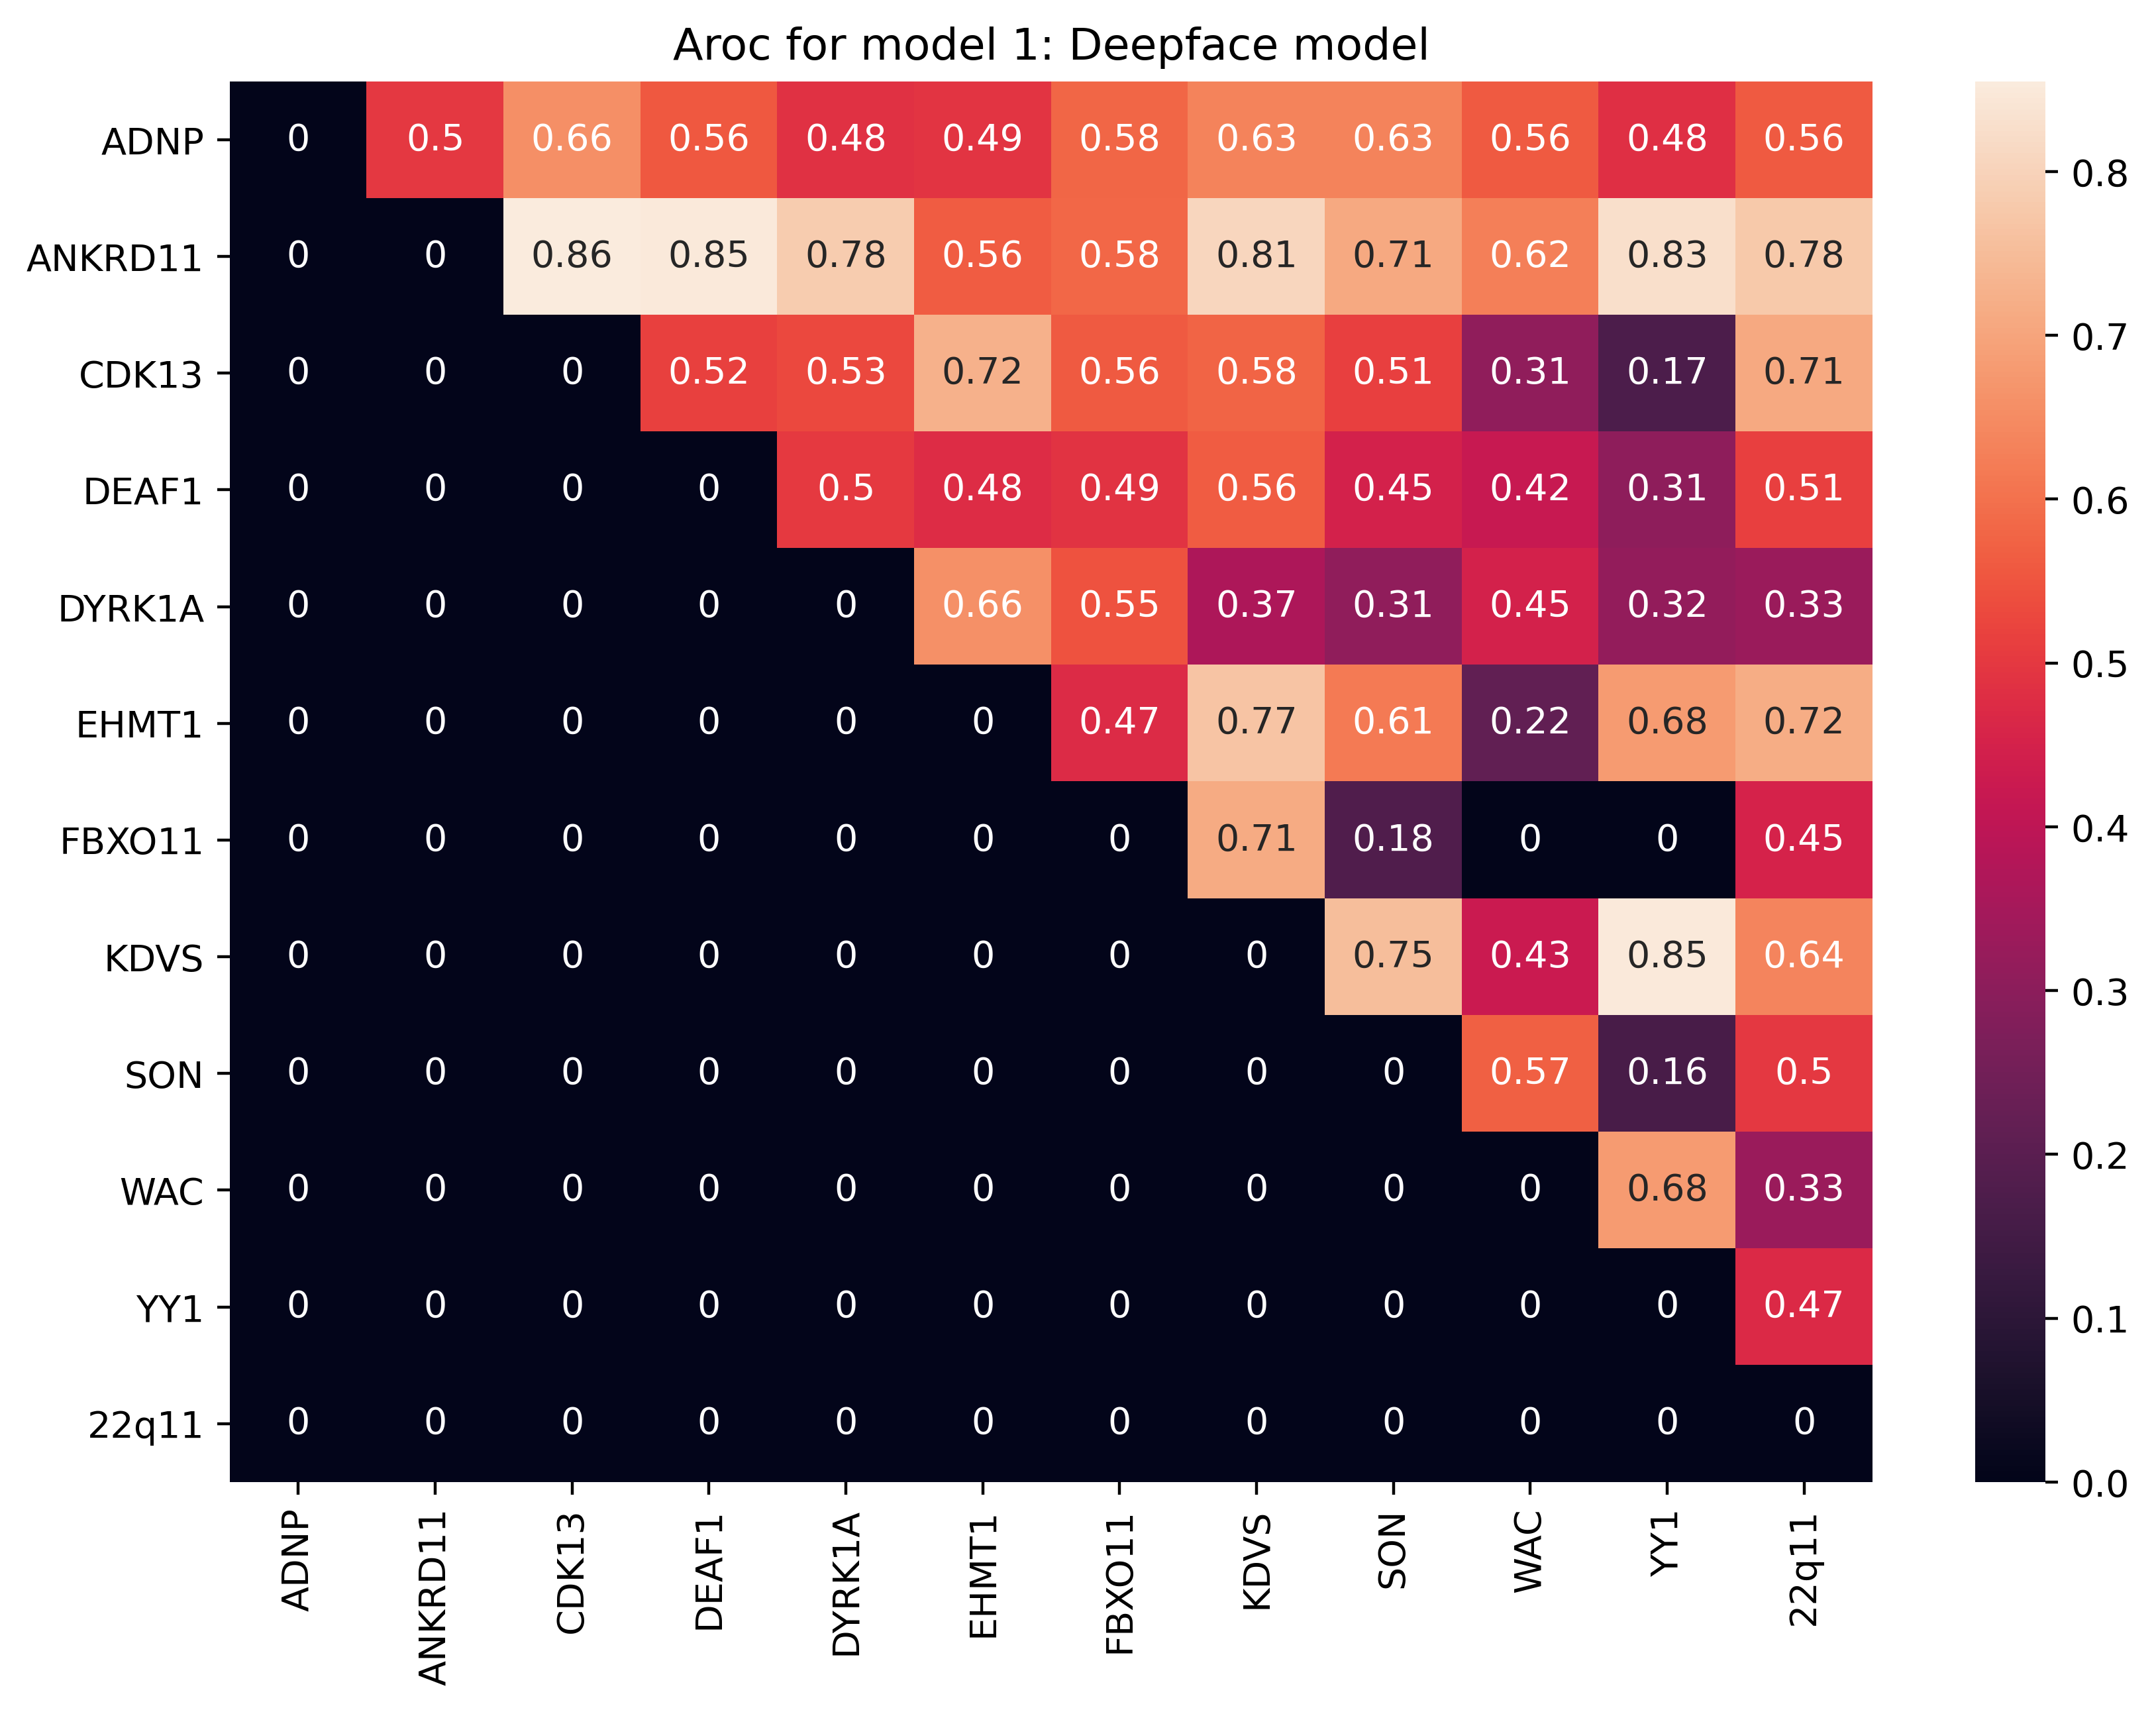

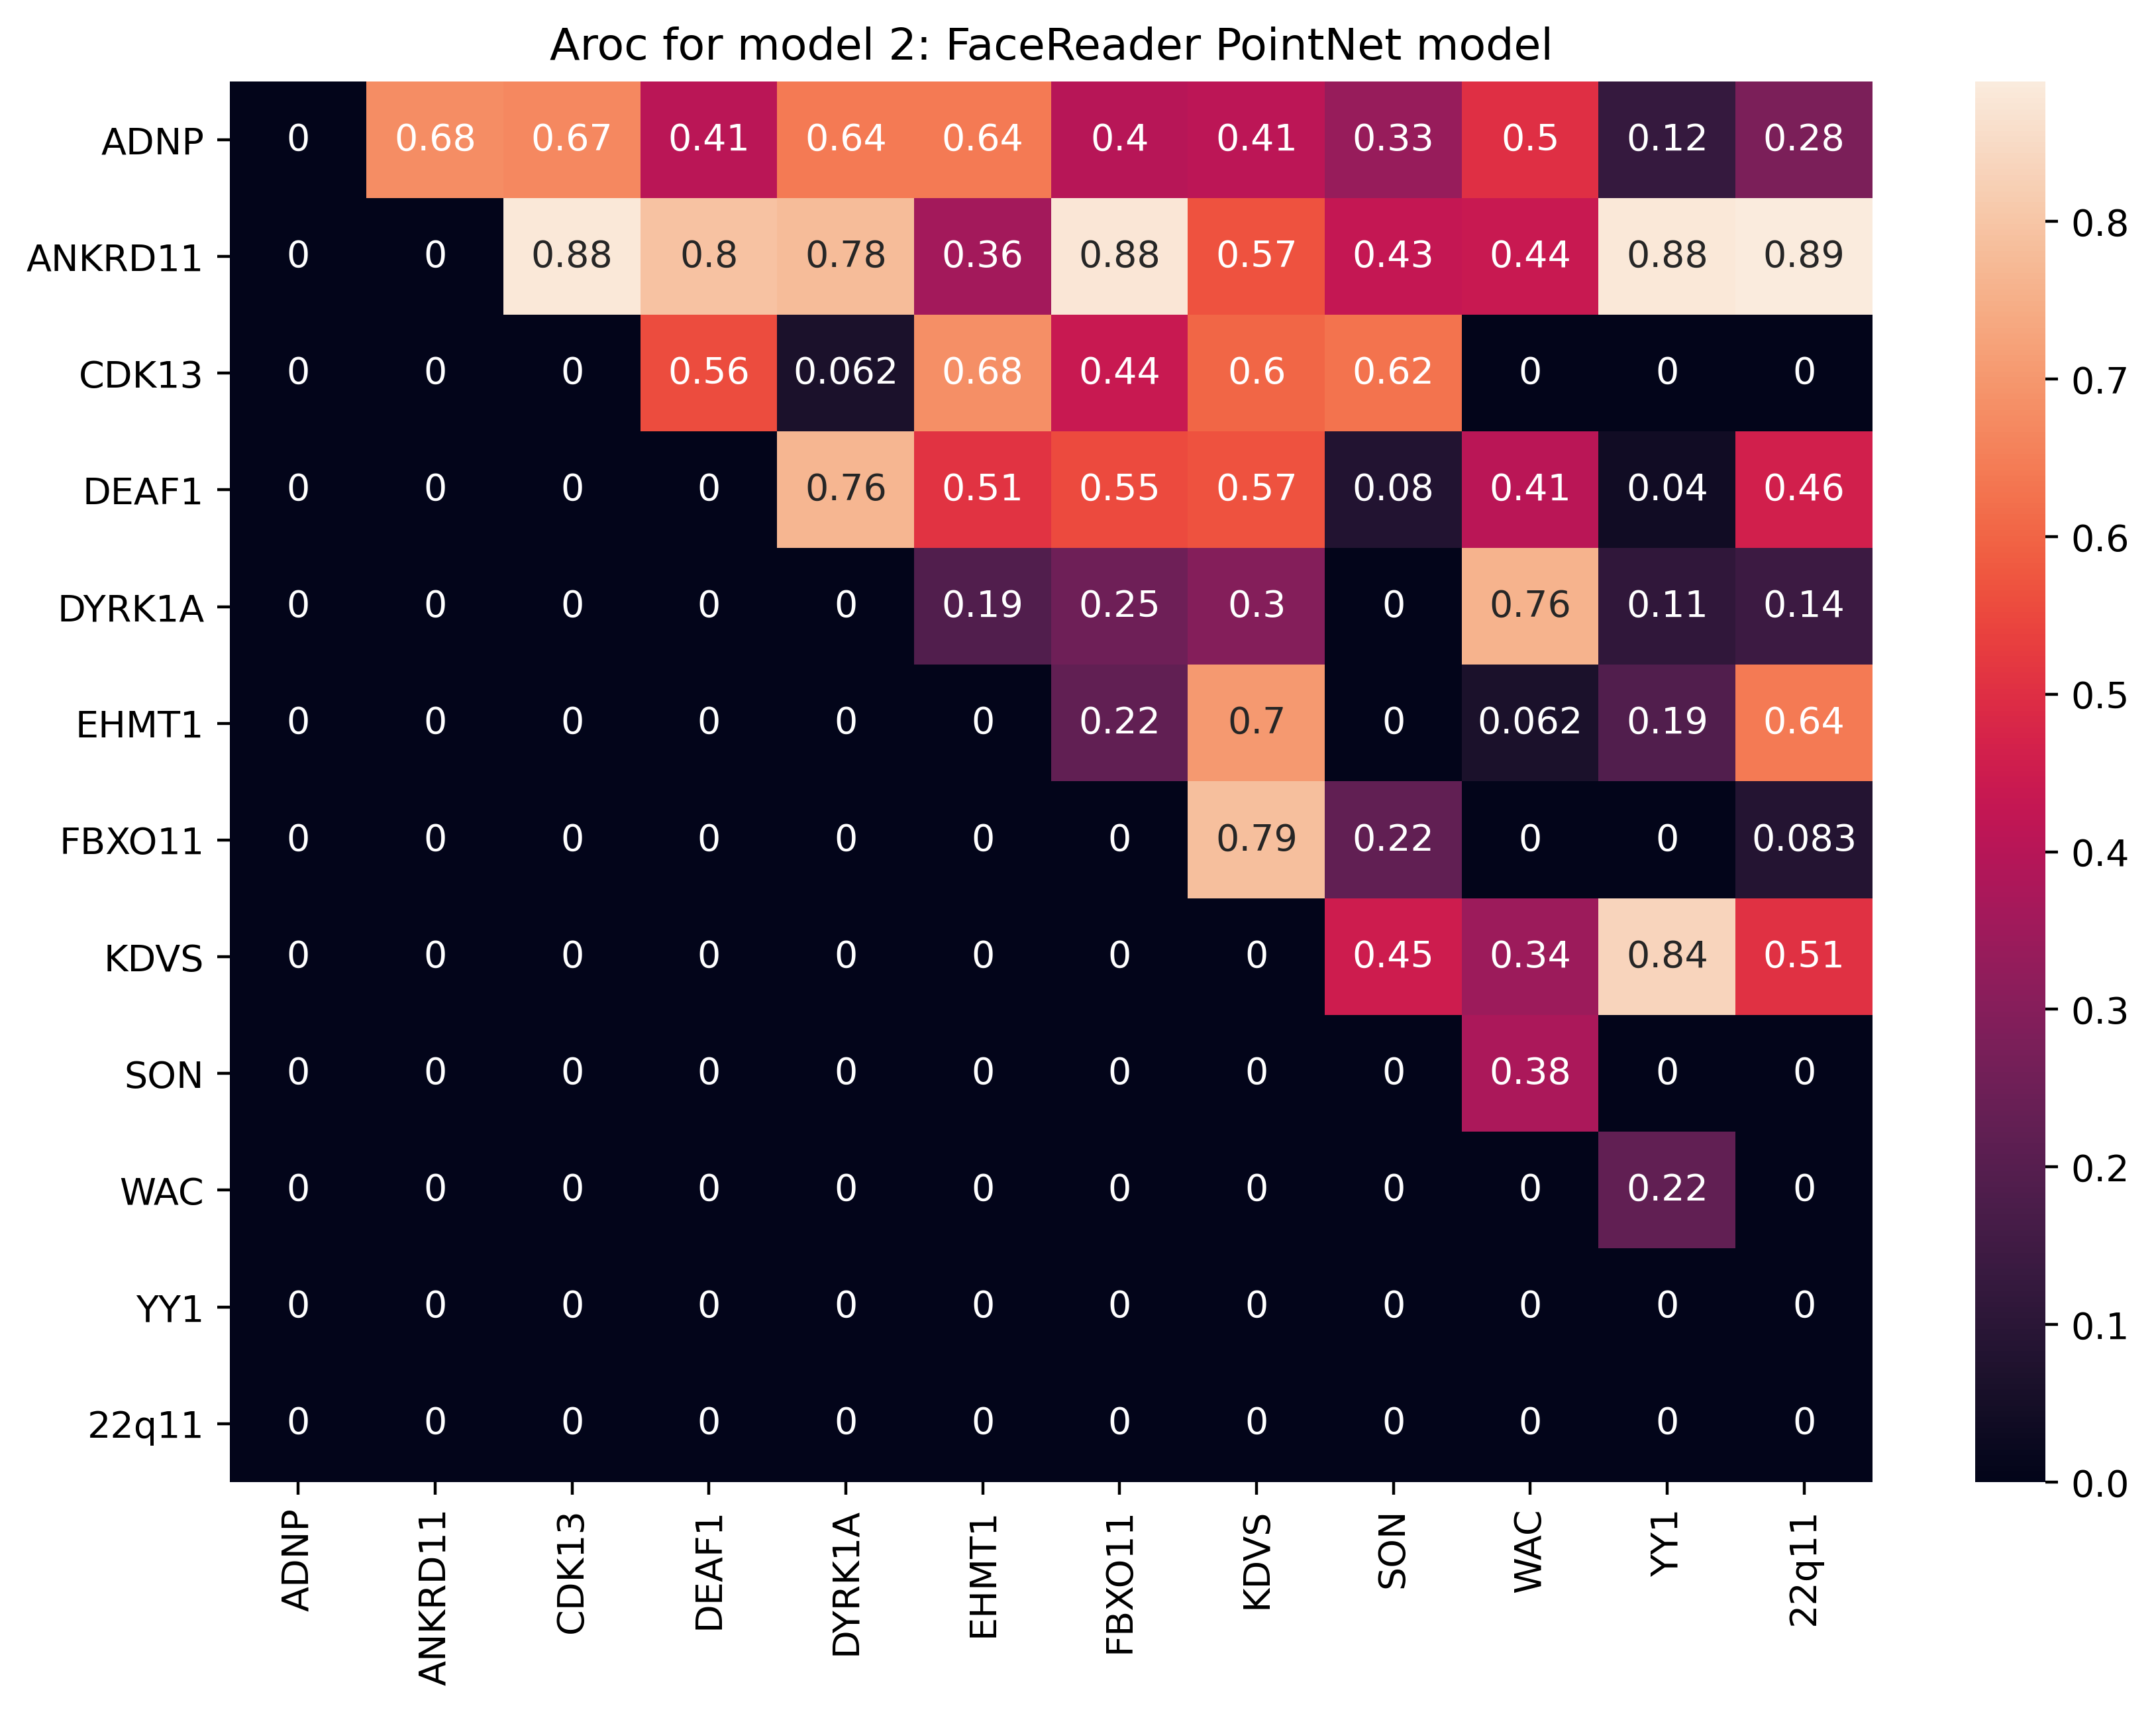

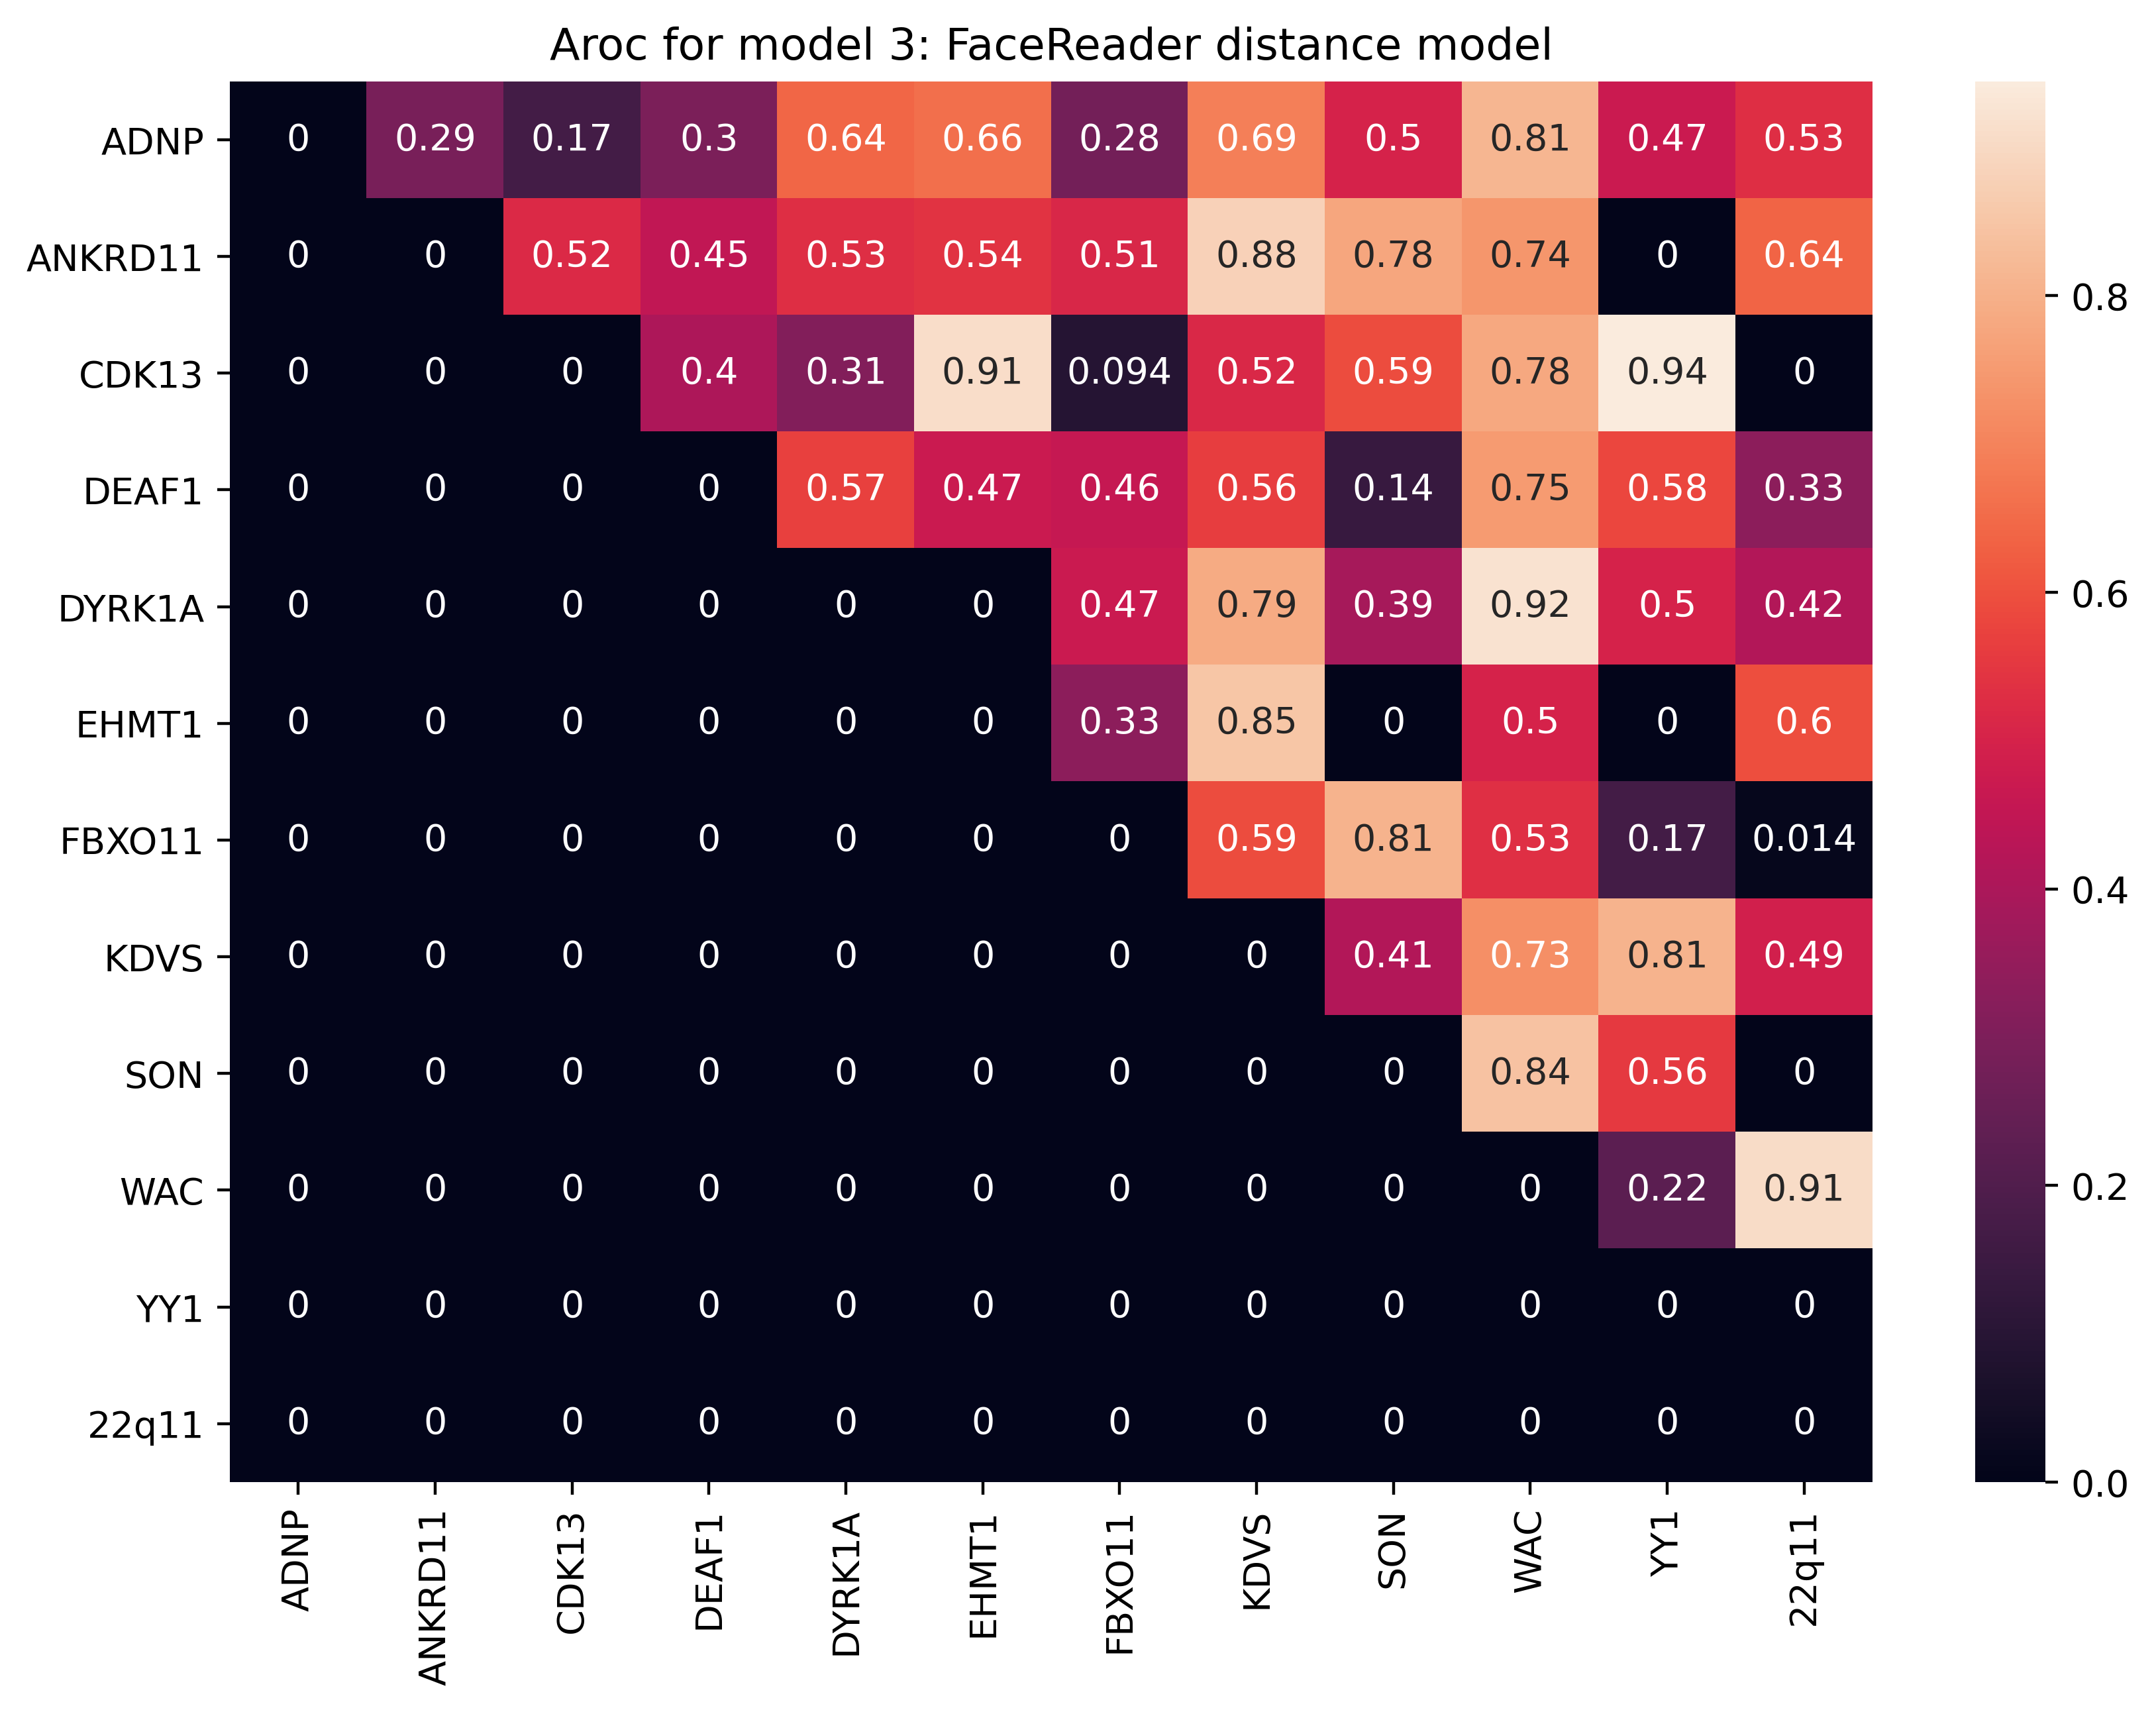

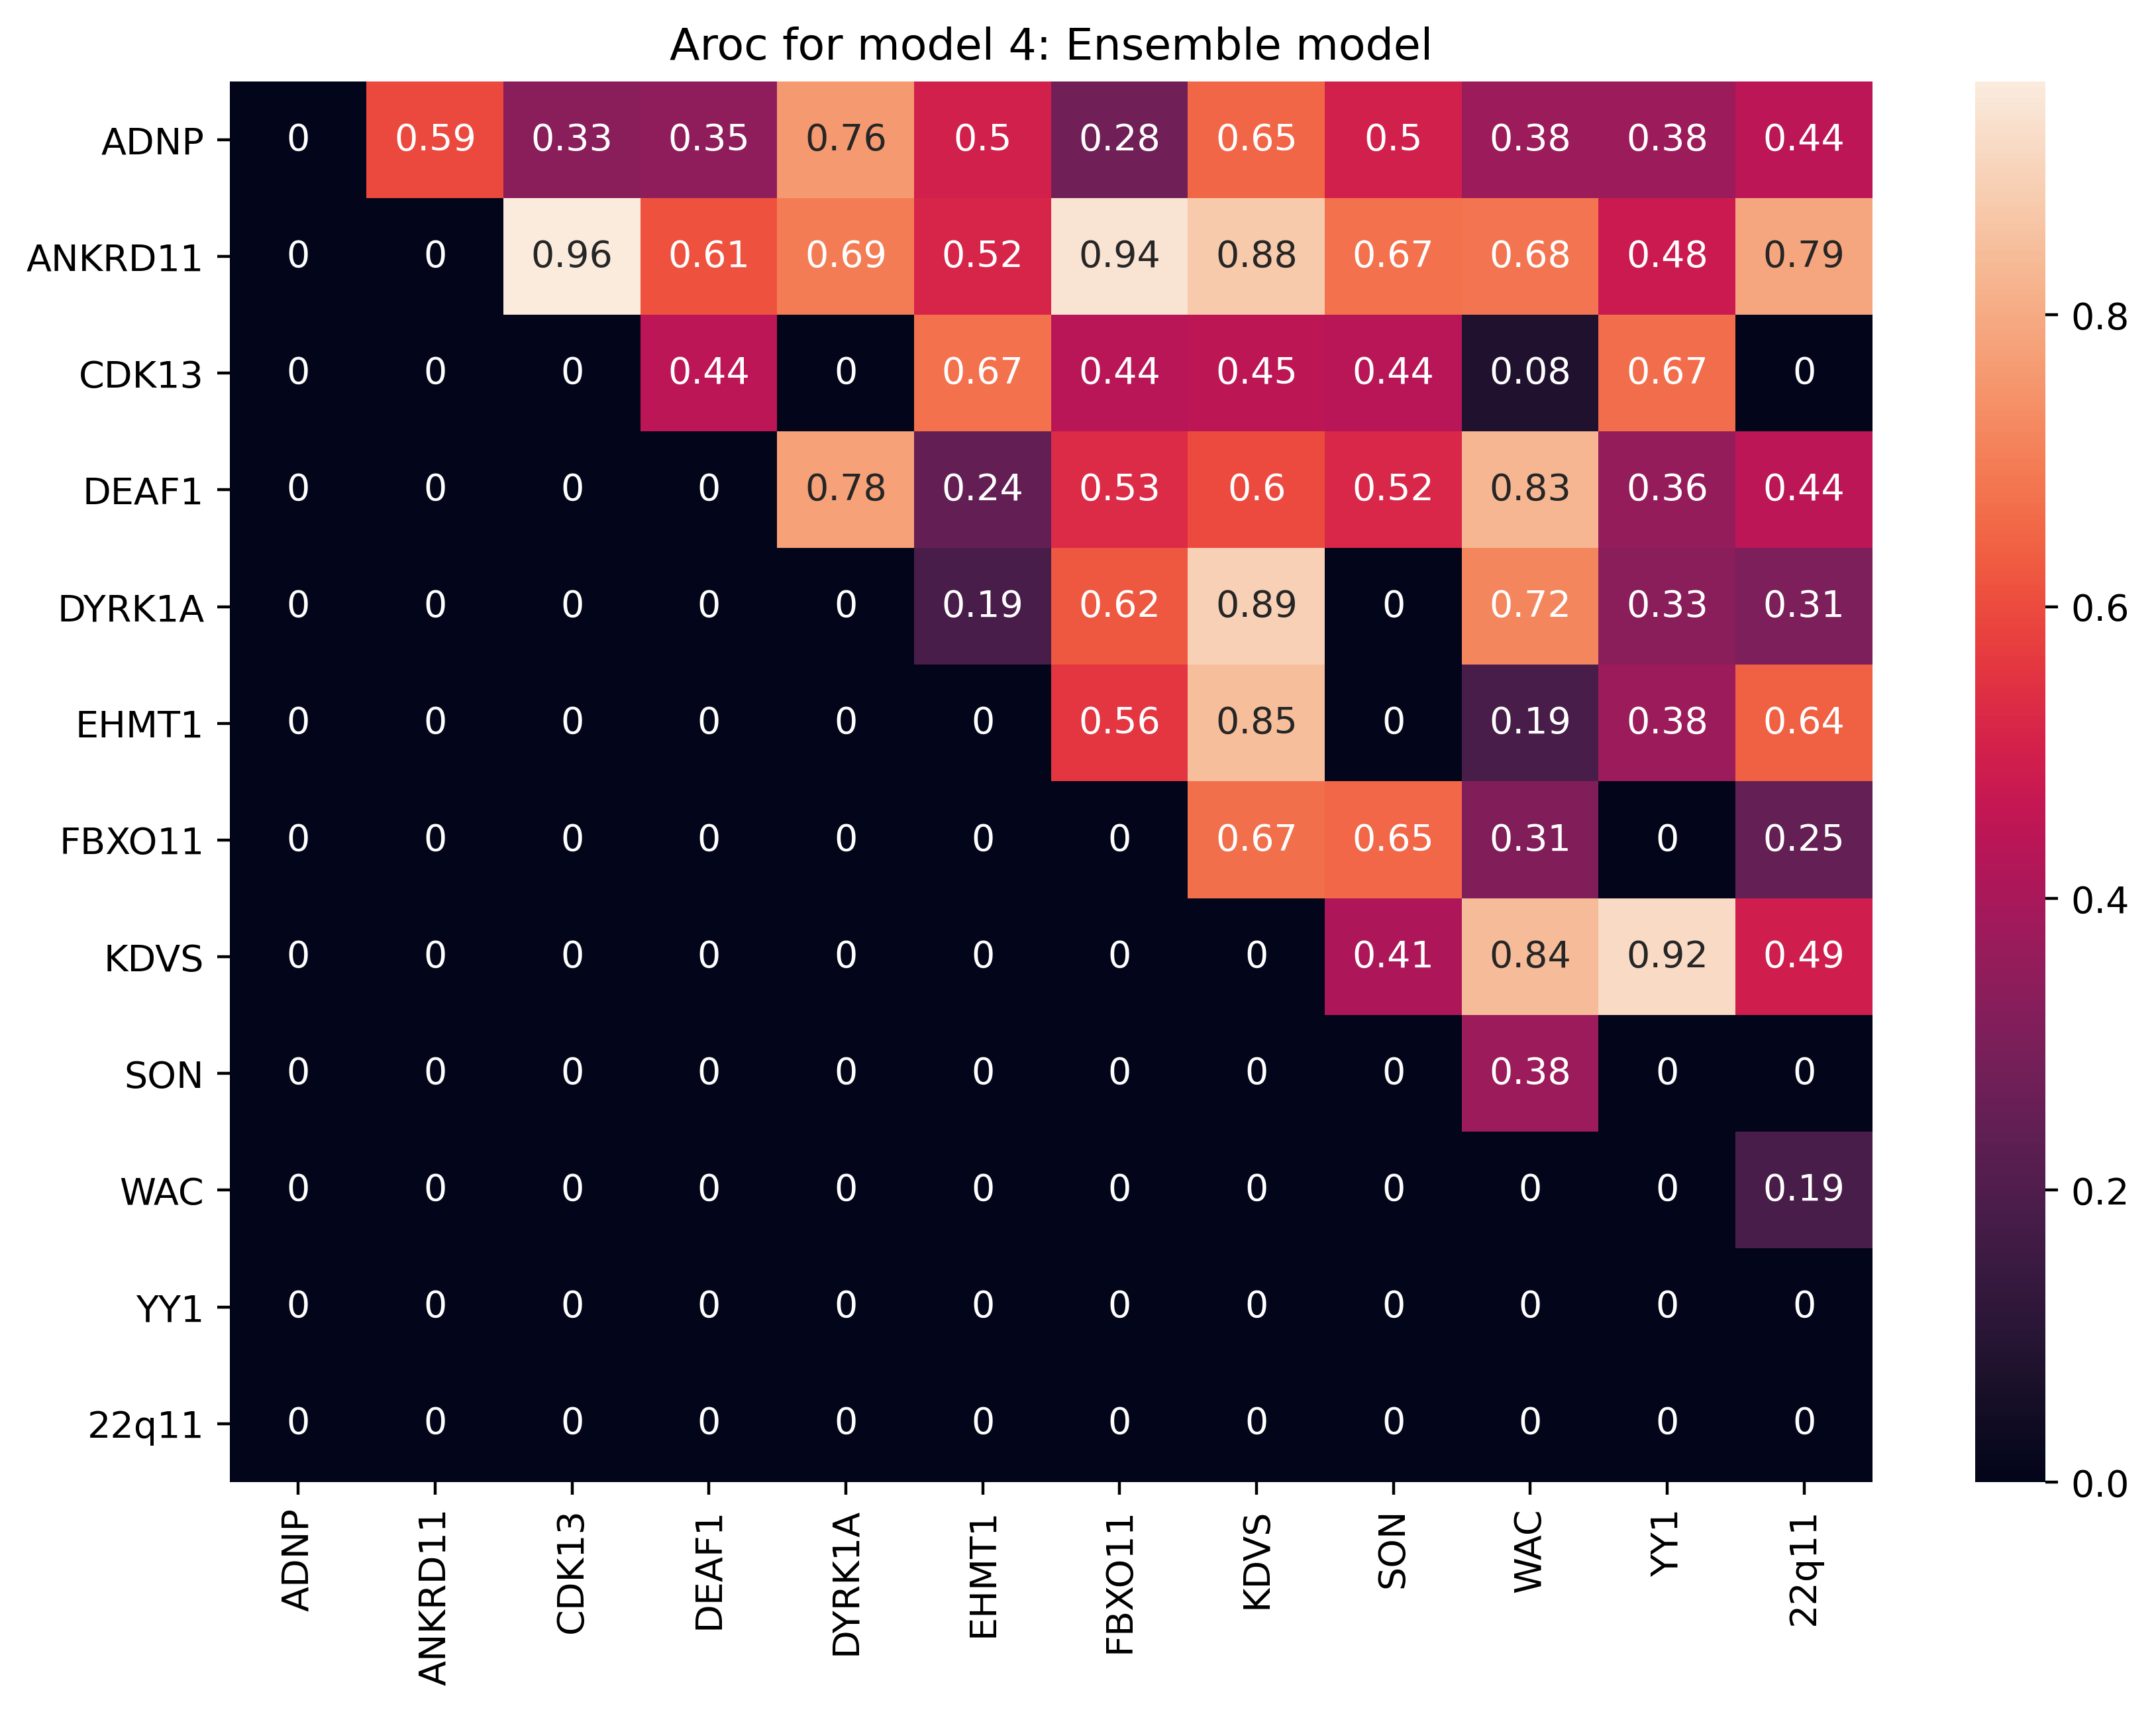

In [16]:
labels = print(list(range(len(syn_list))))

# deepface_all
df_cm = pd.DataFrame(results_df_all, syn_list, syn_list)
plt.figure(figsize = (10,7), dpi=400)
plt.title("Aroc for model 1: Deepface model")
sn.heatmap(df_cm, annot=True)
plt.savefig("results/aroc-deepface.png")

#pointnet
df_cm = pd.DataFrame(results_pn, syn_list, syn_list)
plt.figure(figsize = (10,7), dpi=400)
plt.title("Aroc for model 2: FaceReader PointNet model")
sn.heatmap(df_cm, annot=True)
plt.savefig("results/aroc-facereader-pointnet.png")

# randomforest
df_cm = pd.DataFrame(results_rf, syn_list, syn_list)
plt.figure(figsize = (10,7), dpi=400)
plt.title("Aroc for model 3: FaceReader distance model")
sn.heatmap(df_cm, annot=True)
plt.savefig("results/aroc-facereader-distance.png")

# ensemble
df_cm = pd.DataFrame(results_en, syn_list, syn_list)        
plt.figure(figsize = (10,7), dpi=400)
plt.title("Aroc for model 4: Ensemble model")
sn.heatmap(df_cm, annot=True)
plt.savefig("results/aroc-ensemble.png")

# # # openface-cfps
# df_cm = pd.DataFrame(results_oc, syn_list, syn_list)        
# plt.figure(figsize = (10,7), dpi=400)
# plt.title("Aroc for model 5: Hybrid model")
# sn.heatmap(df_cm, annot=True)
# plt.savefig("results/aroc-hybrid.png")